In [35]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

import seaborn as sns

In [36]:
#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

In [37]:
HOME="/linkhome/rech/genini01/ucv88ce/"
models_path=os.path.join(HOME,"projects/MultilingualCPC/experiments/checkpoints/inftrain" )
eval_path=""

In [38]:
def retrieve_scores( size= [50,100, 200, 400],  models_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/checkpoints/inftrain'):
    fam_dict={}

    #columns = fam_id, size, eval_lang, en_model, fr_model, bil_model, same, diff (same and diff are just the scores from tje model corresponding to th train and eval)
    #do average of within and across
    langs=["EN","FR","EN+FR"]
    for s in sorted(size):
        s=int(s)
        for fam in ["{}".format(str(x).zfill(2)) for x in range(int(32/s*100))] :
            for eval_lang in ['english','french']:
                k = fam+"_"+eval_lang+"_"+str(s)

                values = [fam, int(s), eval_lang]

                for model in langs:
                    path = os.path.join(models_path,model,str(s)+"h",fam,"cpc_small/ABX","**",eval_lang, "ABX_scores.json")
                    json_f = glob(path, recursive=True)
                                        
                    if len(json_f) == 2 and json_f[0].replace("gpu/", "") == json_f[1].replace("gpu/", ""):
                        json_f = [json_f[0].replace("gpu/", "")]
                    
                    json_f = [x for x in json_f if '/0/' not in x] #solve when ABX calculated on checkpoint 0

                    

                    if not json_f :
                        score = np.nan
                    elif len(json_f) > 1:
                        print(json_f)
                        raise ValueError("multiple checkpoint evaluated in {}".format(os.path.join(models_path,"EN",str(s)+"h",fam,"cpc_small/ABX")))
                    else:
                        with open(json_f[0], "r") as f:

                            scores = json.load(f)
                        score = np.mean([scores['within'],scores['across']]) * 100
                    values.append(score)

                    if model == "EN" and eval_lang == "english" :
                        same = score
                    elif model == "EN" and eval_lang == "french" :
                        different = score
                    elif model == "FR" and eval_lang == "french" :
                        same = score
                    elif model == "FR" and eval_lang == "english" :
                        different = score
                        
                    #below we add the "bilingual "

                    if  model == "EN+FR" and fam+"_"+eval_lang+"_"+str(int(s/2)) in fam_dict : #if there exists the key with divided by two 
                        #also need to take into account the new family numberr
                        fam_dict[str(int(fam)*2).zfill(2)+"_"+eval_lang+"_"+str(int(s/2))][-1] = score
                        fam_dict[str(int(fam)*2 + 1).zfill(2)+"_"+eval_lang+"_"+str(int(s/2))][-1] = score


                
                values.append(same)
                values.append(different)
                values.append(np.nan) #eate space for the "bil_add"
                fam_dict[k] = values
                


    

    df = pd.DataFrame.from_dict(fam_dict, orient='index', columns=["fam_id", "size", "eval_lang", "en_model", "fr_model", "bil_totalsize", 'same', 'different', "bil_langsize"])
    return df

In [39]:
df = retrieve_scores()
df

,fam_id,size,eval_lang,en_model,fr_model,bil_totalsize,same,different,bil_langsize
00_english_50,00,50,english,9.381137,10.464748,NaN,9.381137,10.464748,NaN
00_french_50,00,50,french,13.385639,12.934963,NaN,12.934963,13.385639,NaN
01_english_50,01,50,english,8.947467,9.671624,NaN,8.947467,9.671624,NaN
01_french_50,01,50,french,13.729692,12.021576,NaN,12.021576,13.729692,NaN
02_english_50,02,50,english,10.120826,10.051428,NaN,10.120826,10.051428,NaN
...,...,...,...,...,...,...,...,...,...
05_french_400,05,400,french,13.103735,13.323646,NaN,13.323646,13.103735,NaN
06_english_400,06,400,english,9.908761,11.320041,NaN,9.908761,11.320041,NaN
06_french_400,06,400,french,13.716604,12.090449,11.322327,12.090449,13.716604,NaN
07_english_400,07,400,english,9.507519,11.996425,NaN,9.507519,11.996425,NaN


In [40]:
df.loc['23_english_50']

fam_id                  23
size                    50
eval_lang          english
en_model         12.384449
fr_model         13.743448
bil_totalsize          NaN
same             12.384449
different        13.743448
bil_langsize           NaN
Name: 23_english_50, dtype: object

In [41]:
from scipy import stats


#HIS IS WRONG - IT SHOULD BE DONE AT THE SIZE LEVEL !! 
def drop_outliers(df, columns = ["en_model", "fr_model", "bil_totalsize"],z_thresh=3):
    #removew outliers but also the famil which are linked to the one removed. 
    excluded_fam = set()
    size_list = df['size'].unique()
    for size in size_list :
        for col in columns:
            z = np.abs(stats.zscore(df[col]))
            for s in list(df[z >= 3]["fam_id"]):
                excluded_fam.add((size,s))
    
    excluded_fam_final=excluded_fam.copy()
    for s,f in excluded_fam : 
        f = int(f)
        for new_s in size_list : 
            if s > new_s : 
                for x in range(int(s / new_s)) :
                    new_f = math.trunc(f / (new_s / s)) + x
                    excluded_fam_final.add((new_s, str(new_f).zfill(2)))

            elif s < new_s : 

                new_f = math.trunc(f * (new_s / s))
                excluded_fam_final.add((new_s, str(new_f).zfill(2)))

    return df[~ df.apply(lambda row: (row['size'], row['fam_id']) in excluded_fam_final, axis=1)]


In [42]:
#filter df
df = retrieve_scores()
df["mono_avg"] = df[["en_model", "fr_model"]].mean(axis=1)
df.to_csv('tmp.csv')
#df = df[(df["en_model"].notna()) & (df["fr_model"].notna())]


df_200h = df[df["size"]==200]
df_100h = df[df["size"]==100]
df_400h = df[df["size"]==400]
df_200_400h = df[(df["size"]==200) | (df["size"]==400)]


df_size = df.groupby(by="size").mean()

df_filt = df[(df["en_model"] < 20 ) & (df["fr_model"] < 20 ) ]
df_filt_size =df_filt.groupby(by="size").mean()

# In df_filt_strict we remove the families with outliers but also all families which are contained in other families etc. 
df_filt_strict = drop_outliers(df)
df_filt_strict_size = df_filt_strict.groupby(by="size").mean()
df_filt_strict_size_lang = df_filt_strict.groupby(by=["size", "eval_lang"]).mean()
df_filt_strict_size


,en_model,fr_model,bil_totalsize,same,different,bil_langsize,mono_avg
size,,,,,,,
50,13.371798,14.473931,NaN,13.468879,14.386112,10.729347,13.982845
100,12.922384,13.718177,10.729347,12.681469,13.917208,10.418130,13.263522
200,12.007472,12.889195,10.418130,11.710002,13.127883,10.209689,12.443487
400,11.468533,12.231759,10.209689,11.186932,12.513359,NaN,11.850146


In [ ]:
boxplot = df_200_400h[['en_model', 'fr_model', 'bil_totalsize', 'eval_lang']].boxplot(by='eval_lang', return_type='axes')
for bp in boxplot: 
    bp.set_ylabel('ABX error rate (in %)')
    bp.set_xlabel('Test Language')

# Here again just to show fundamental to look at it symmetrically as our test sets are not balancd (still looking into rules with XN)

In [ ]:
boxplot = df[['size','en_model', 'fr_model', 'bil_totalsize','bil_langsize',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
for bp in boxplot: 
    bp.set_ylabel('ABX error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 1.0, 'ABX error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h and 400h')

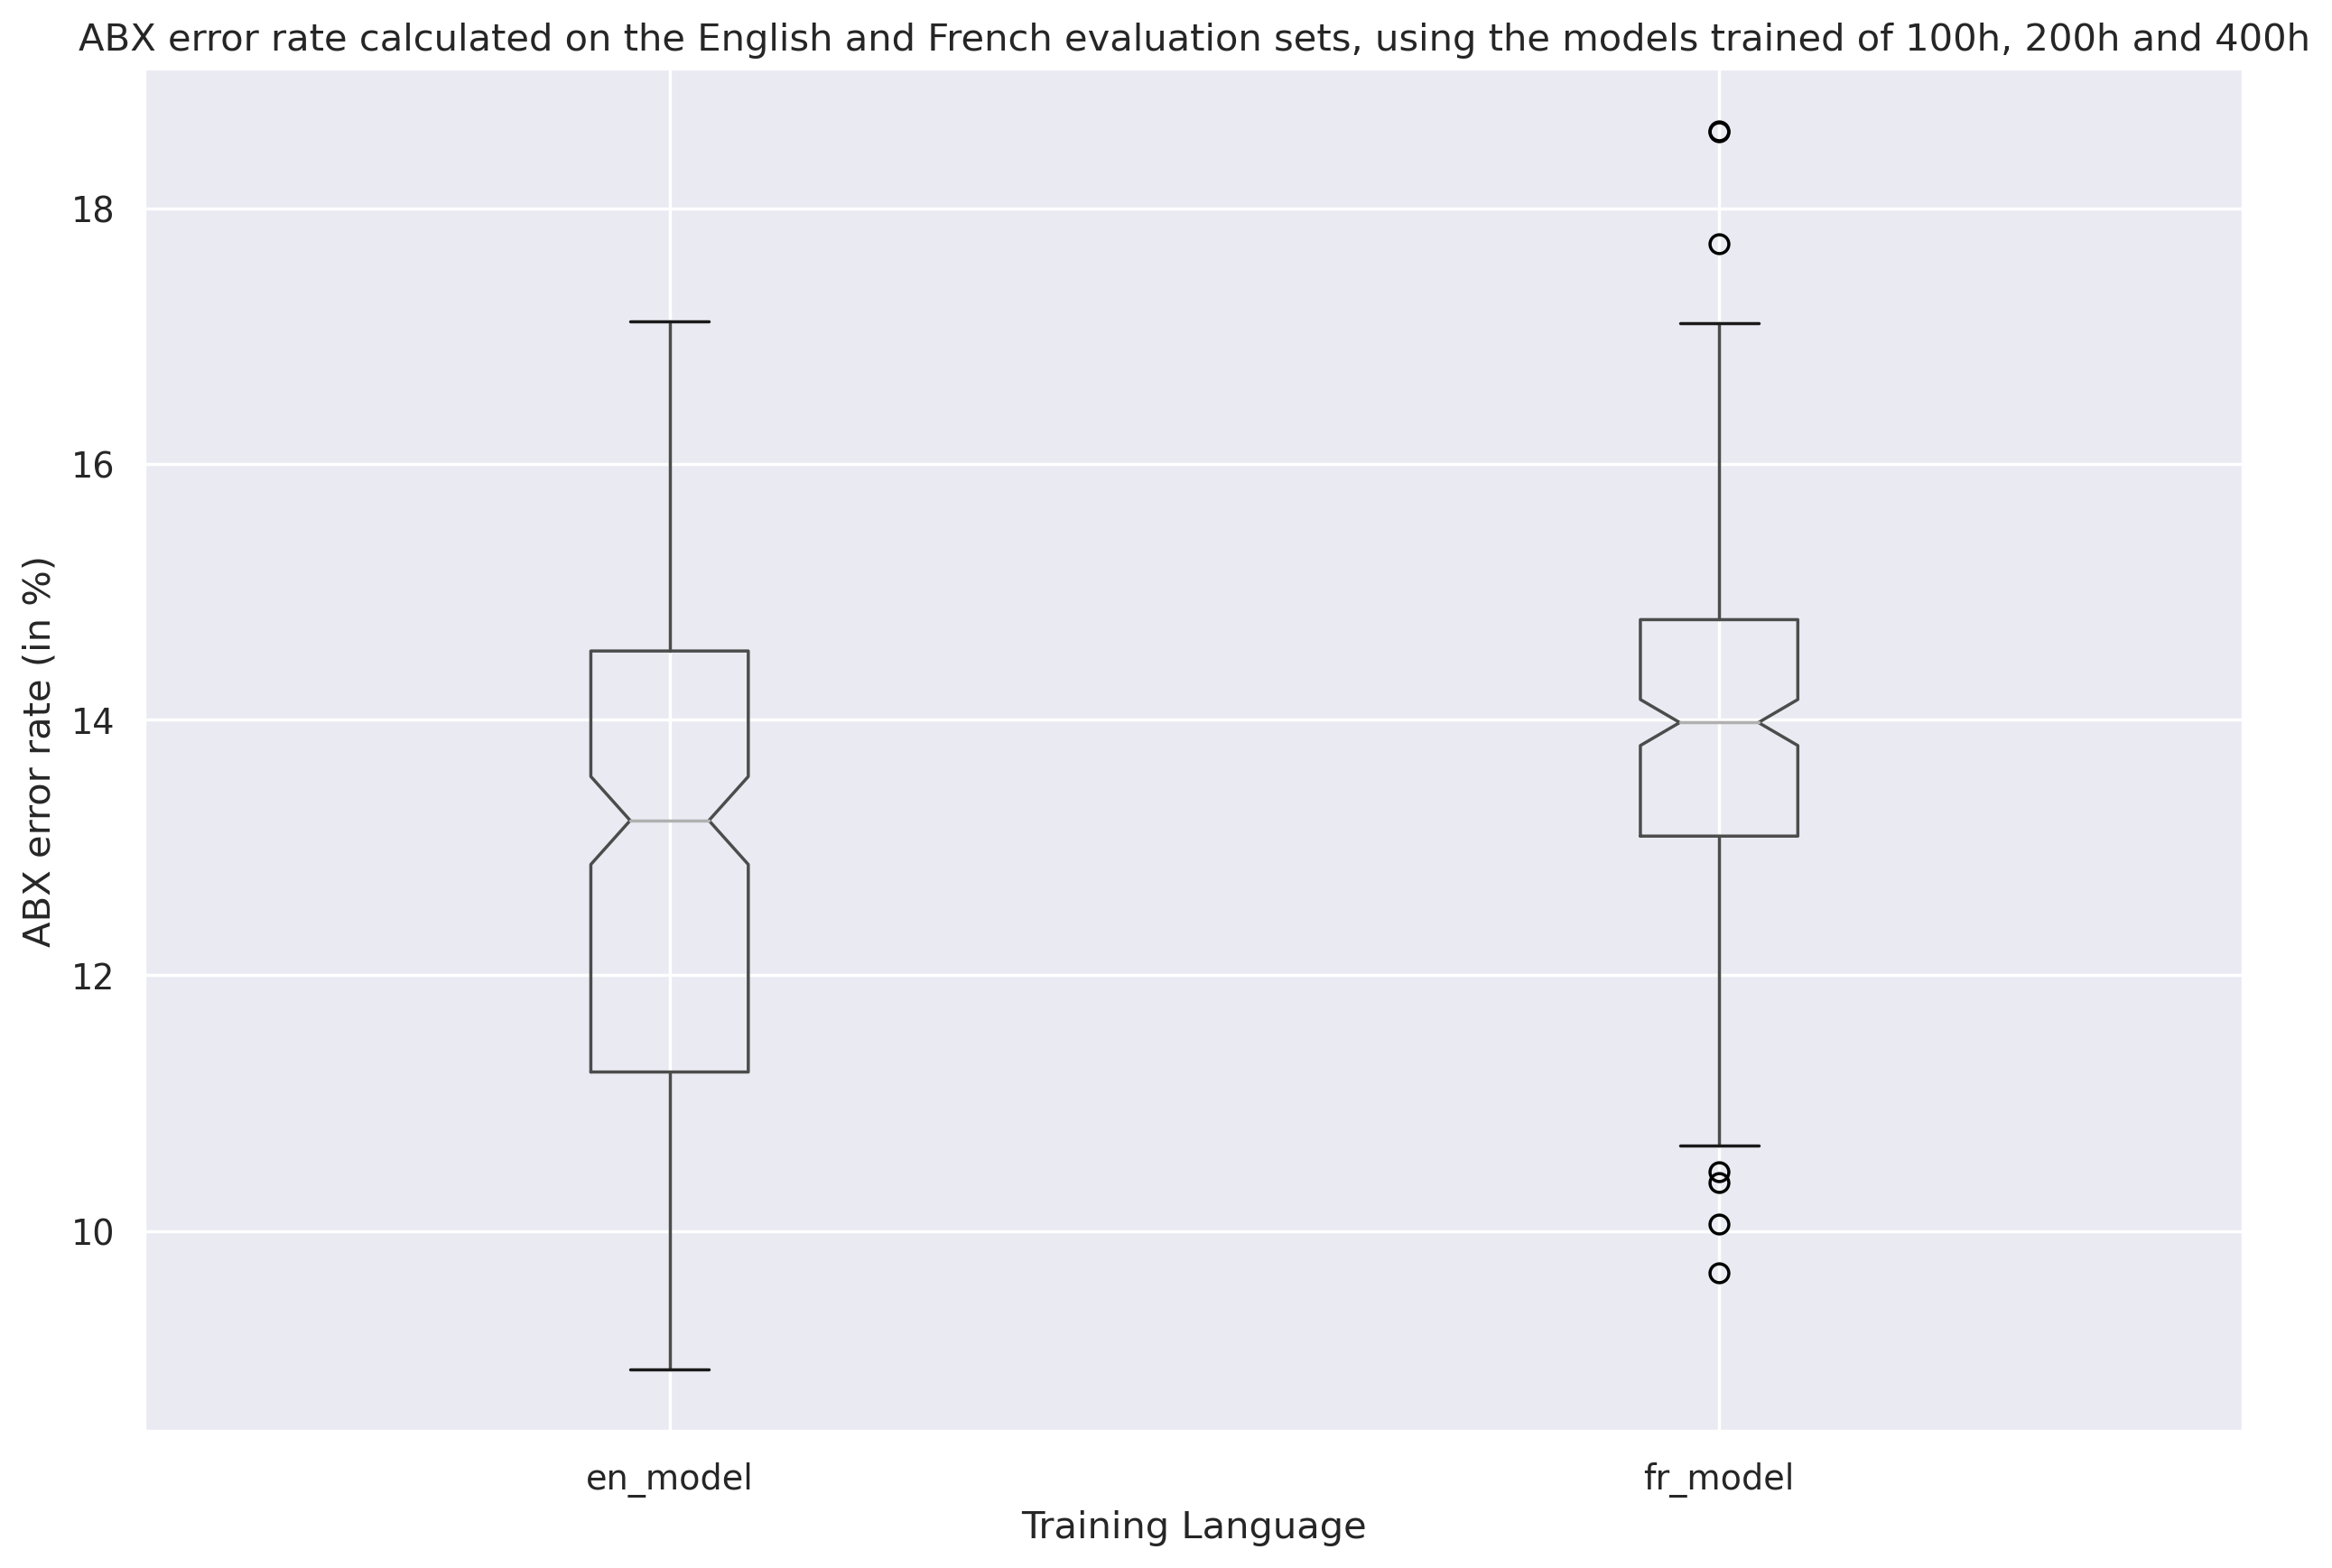

In [25]:
boxplot = df[['en_model', 'fr_model', 'eval_lang']].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h and 400h')



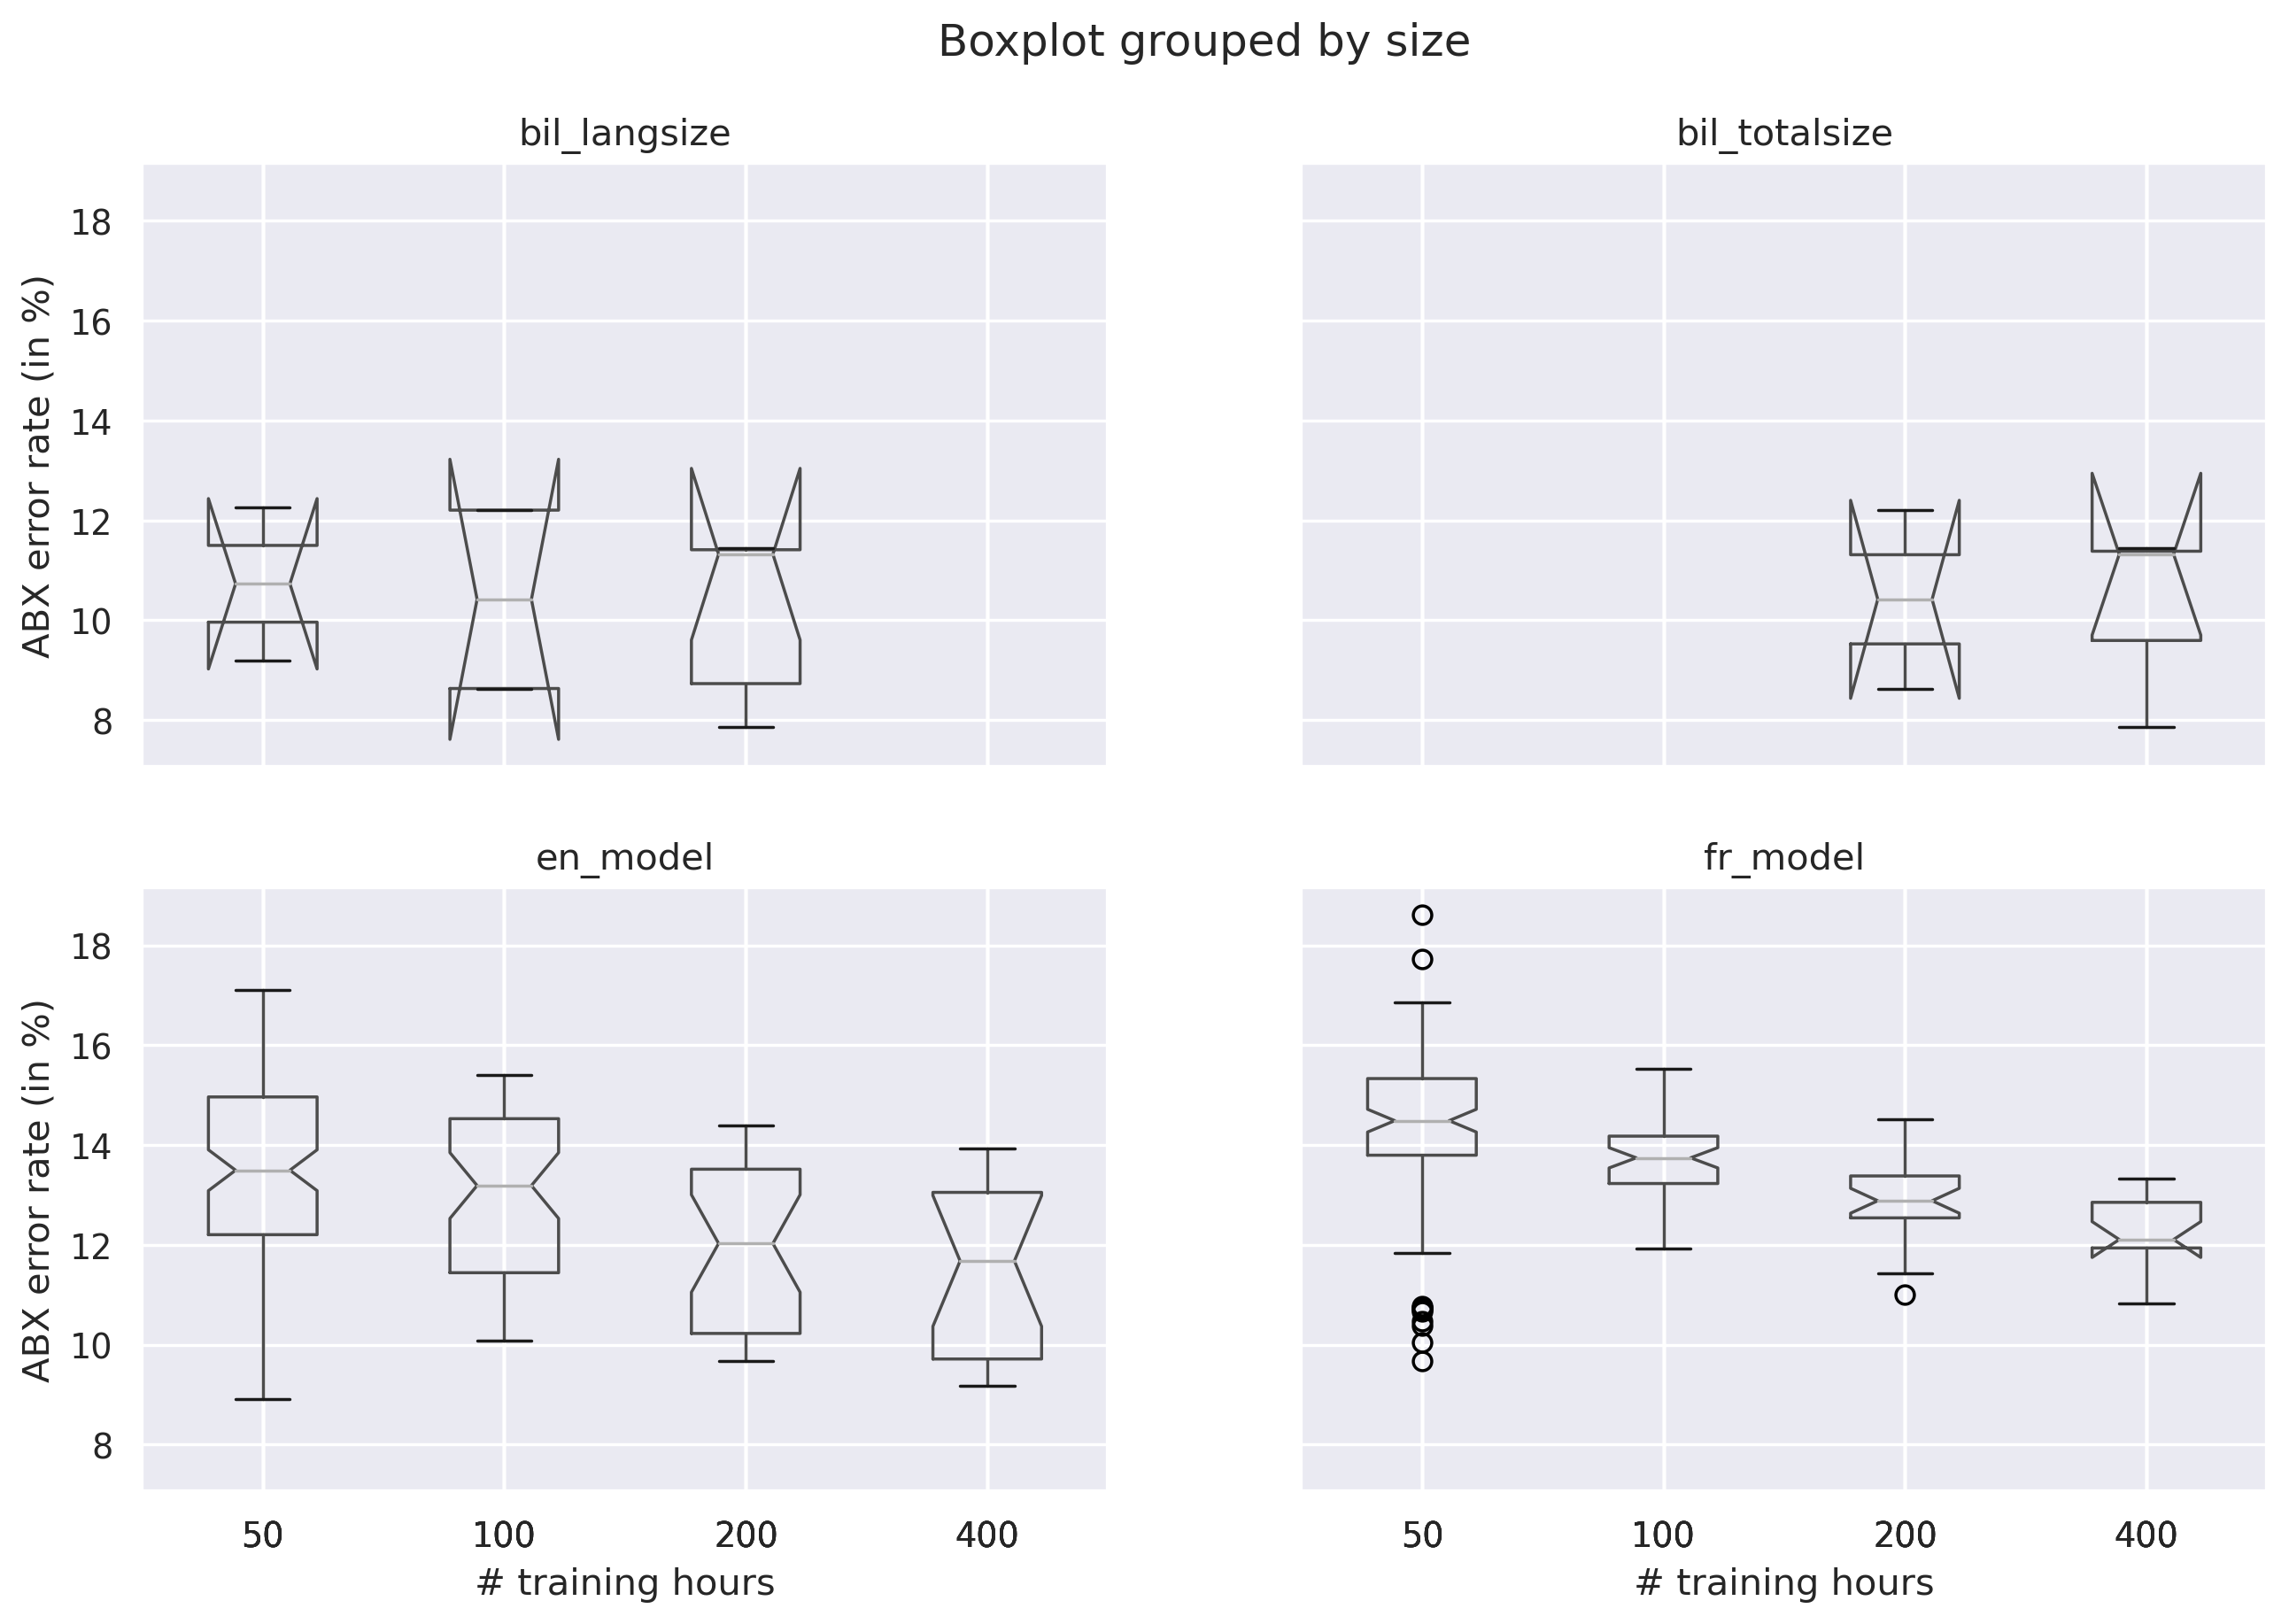

In [26]:
boxplot = df_filt[['size','en_model', 'fr_model', 'bil_totalsize', 'bil_langsize', 'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
for bp in boxplot: 
    bp.set_ylabel('ABX error rate (in %)')
    bp.set_xlabel('# training hours')


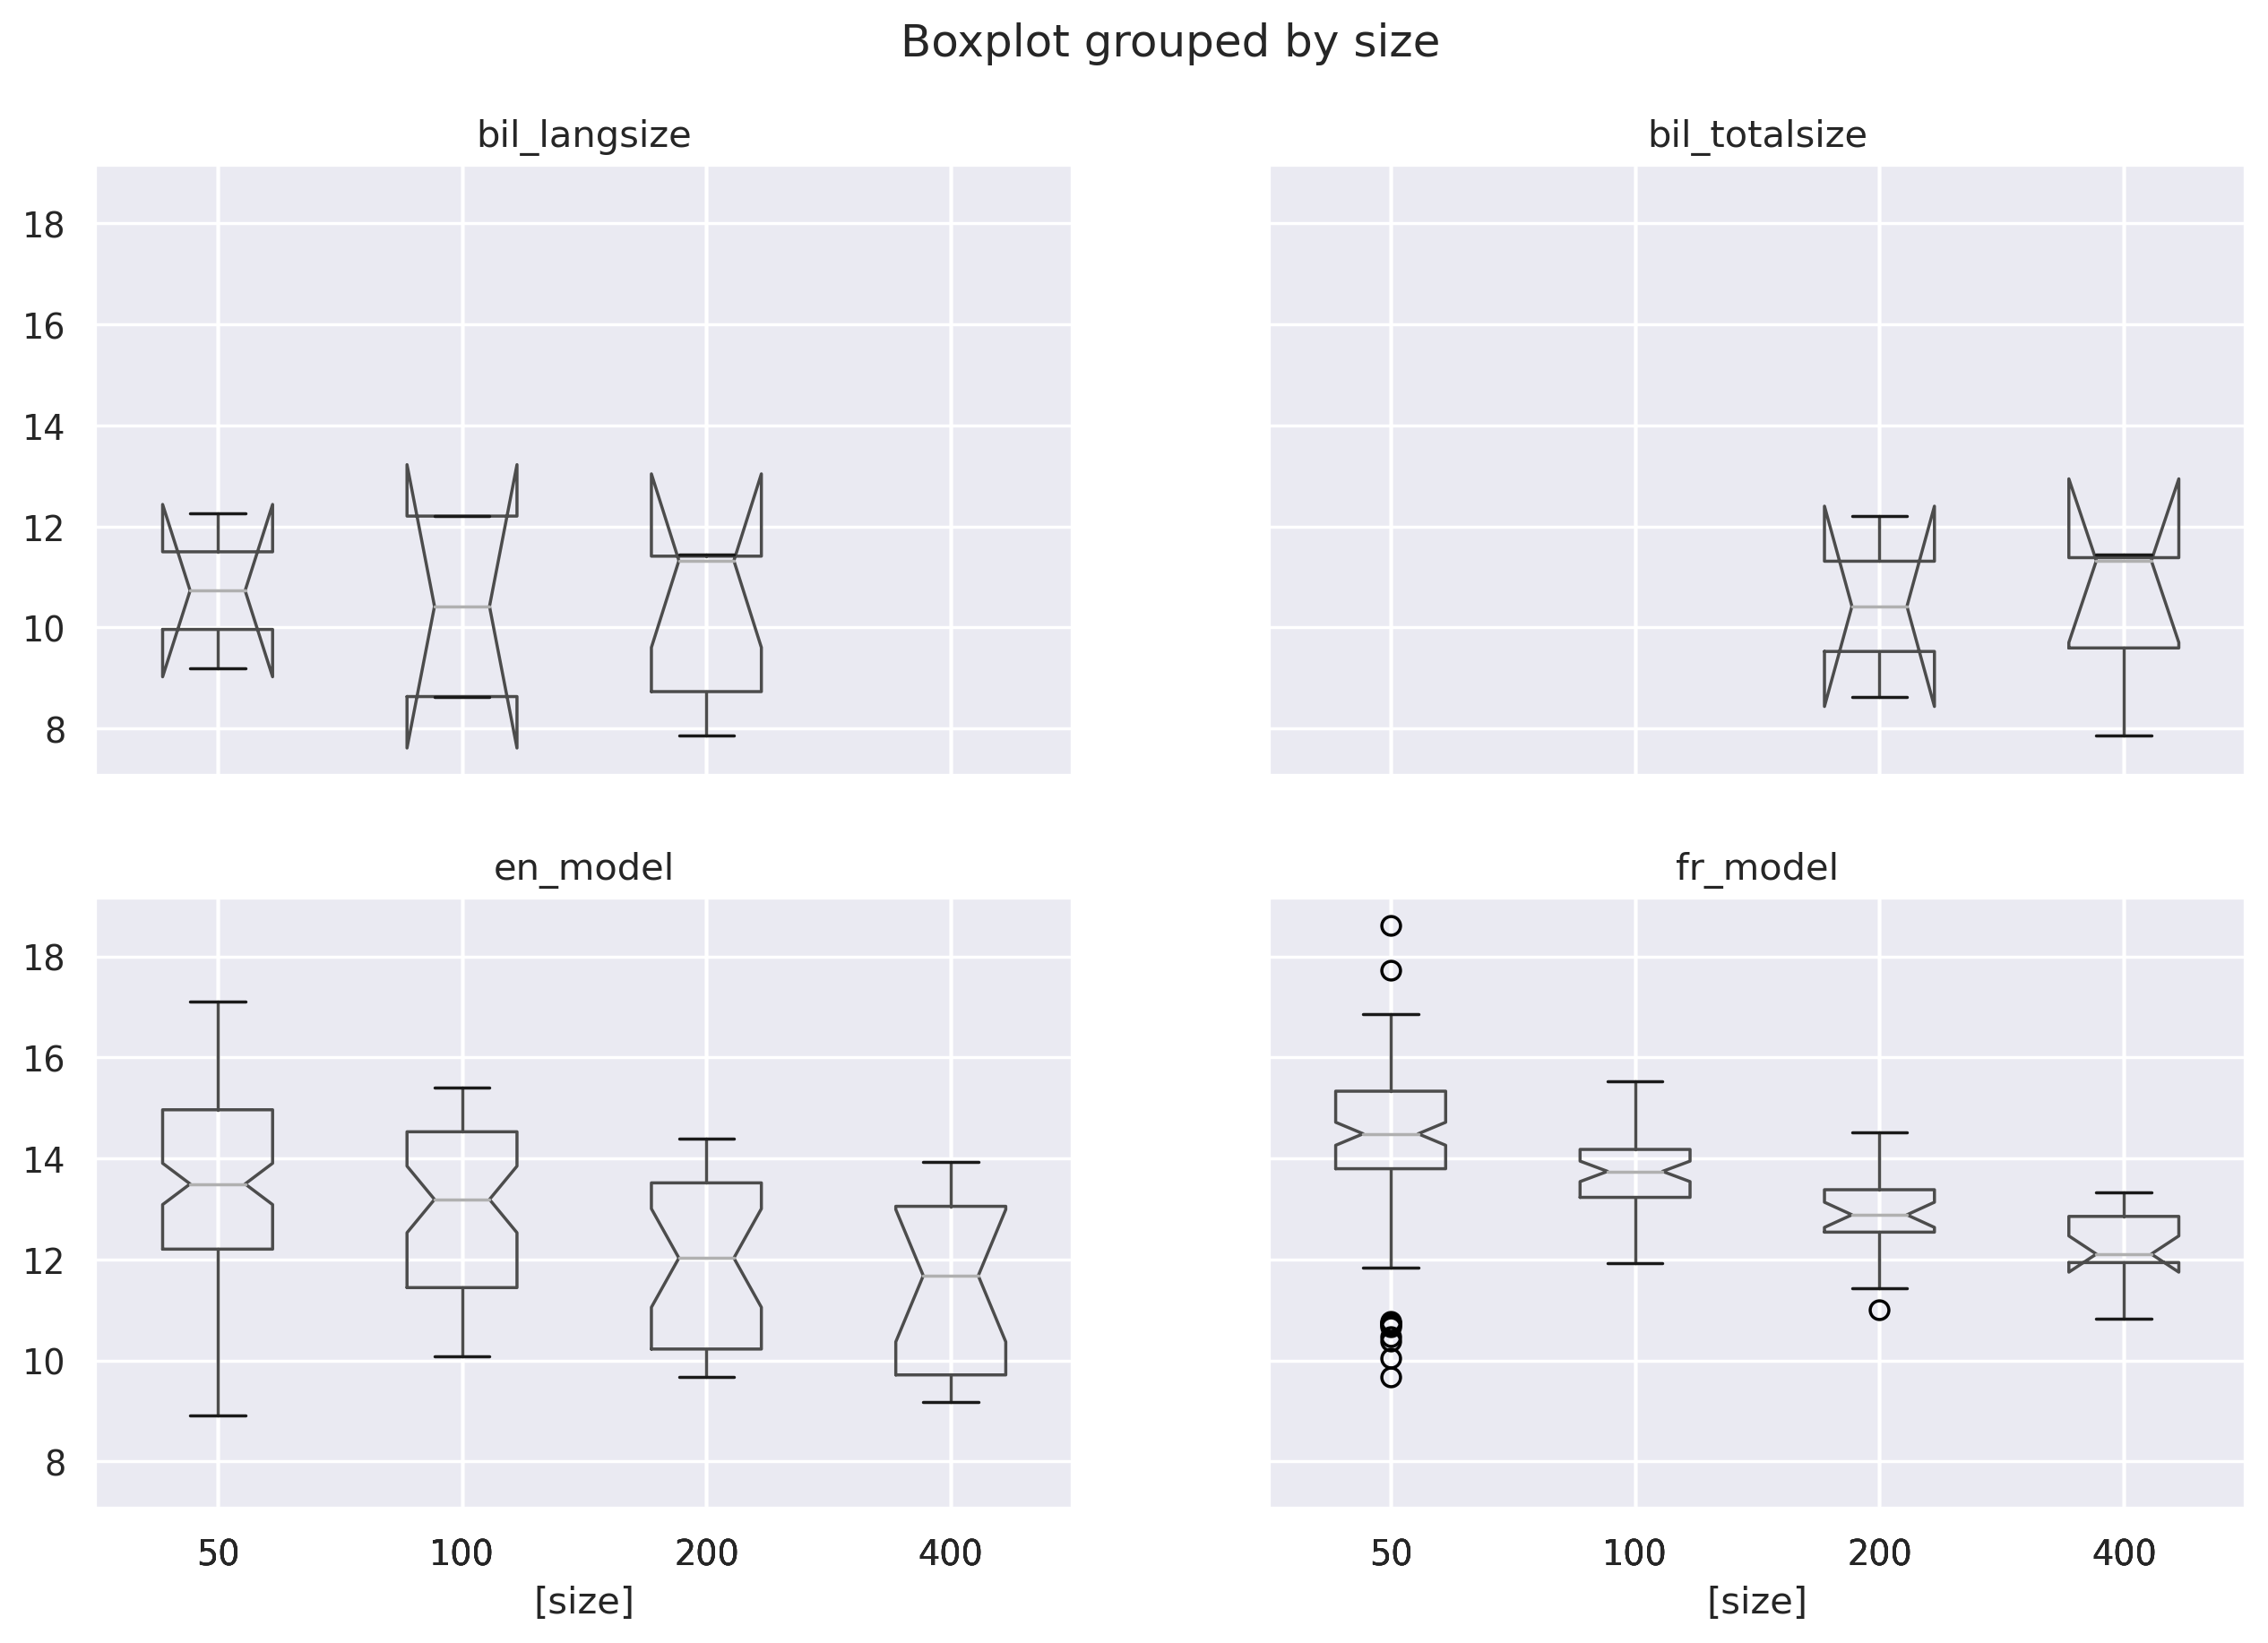

In [27]:
boxplot = df_filt[['size','en_model', 'fr_model', 'bil_totalsize', 'bil_langsize', 'eval_lang']].boxplot(notch=True,by='size', return_type='axes')


In [28]:
style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--', 'mono_avg':'wo-.'}


Text(0.5, 1.0, 'ABX error rate depending on the model type and number of trainig hours, on the unfiltered dataset')

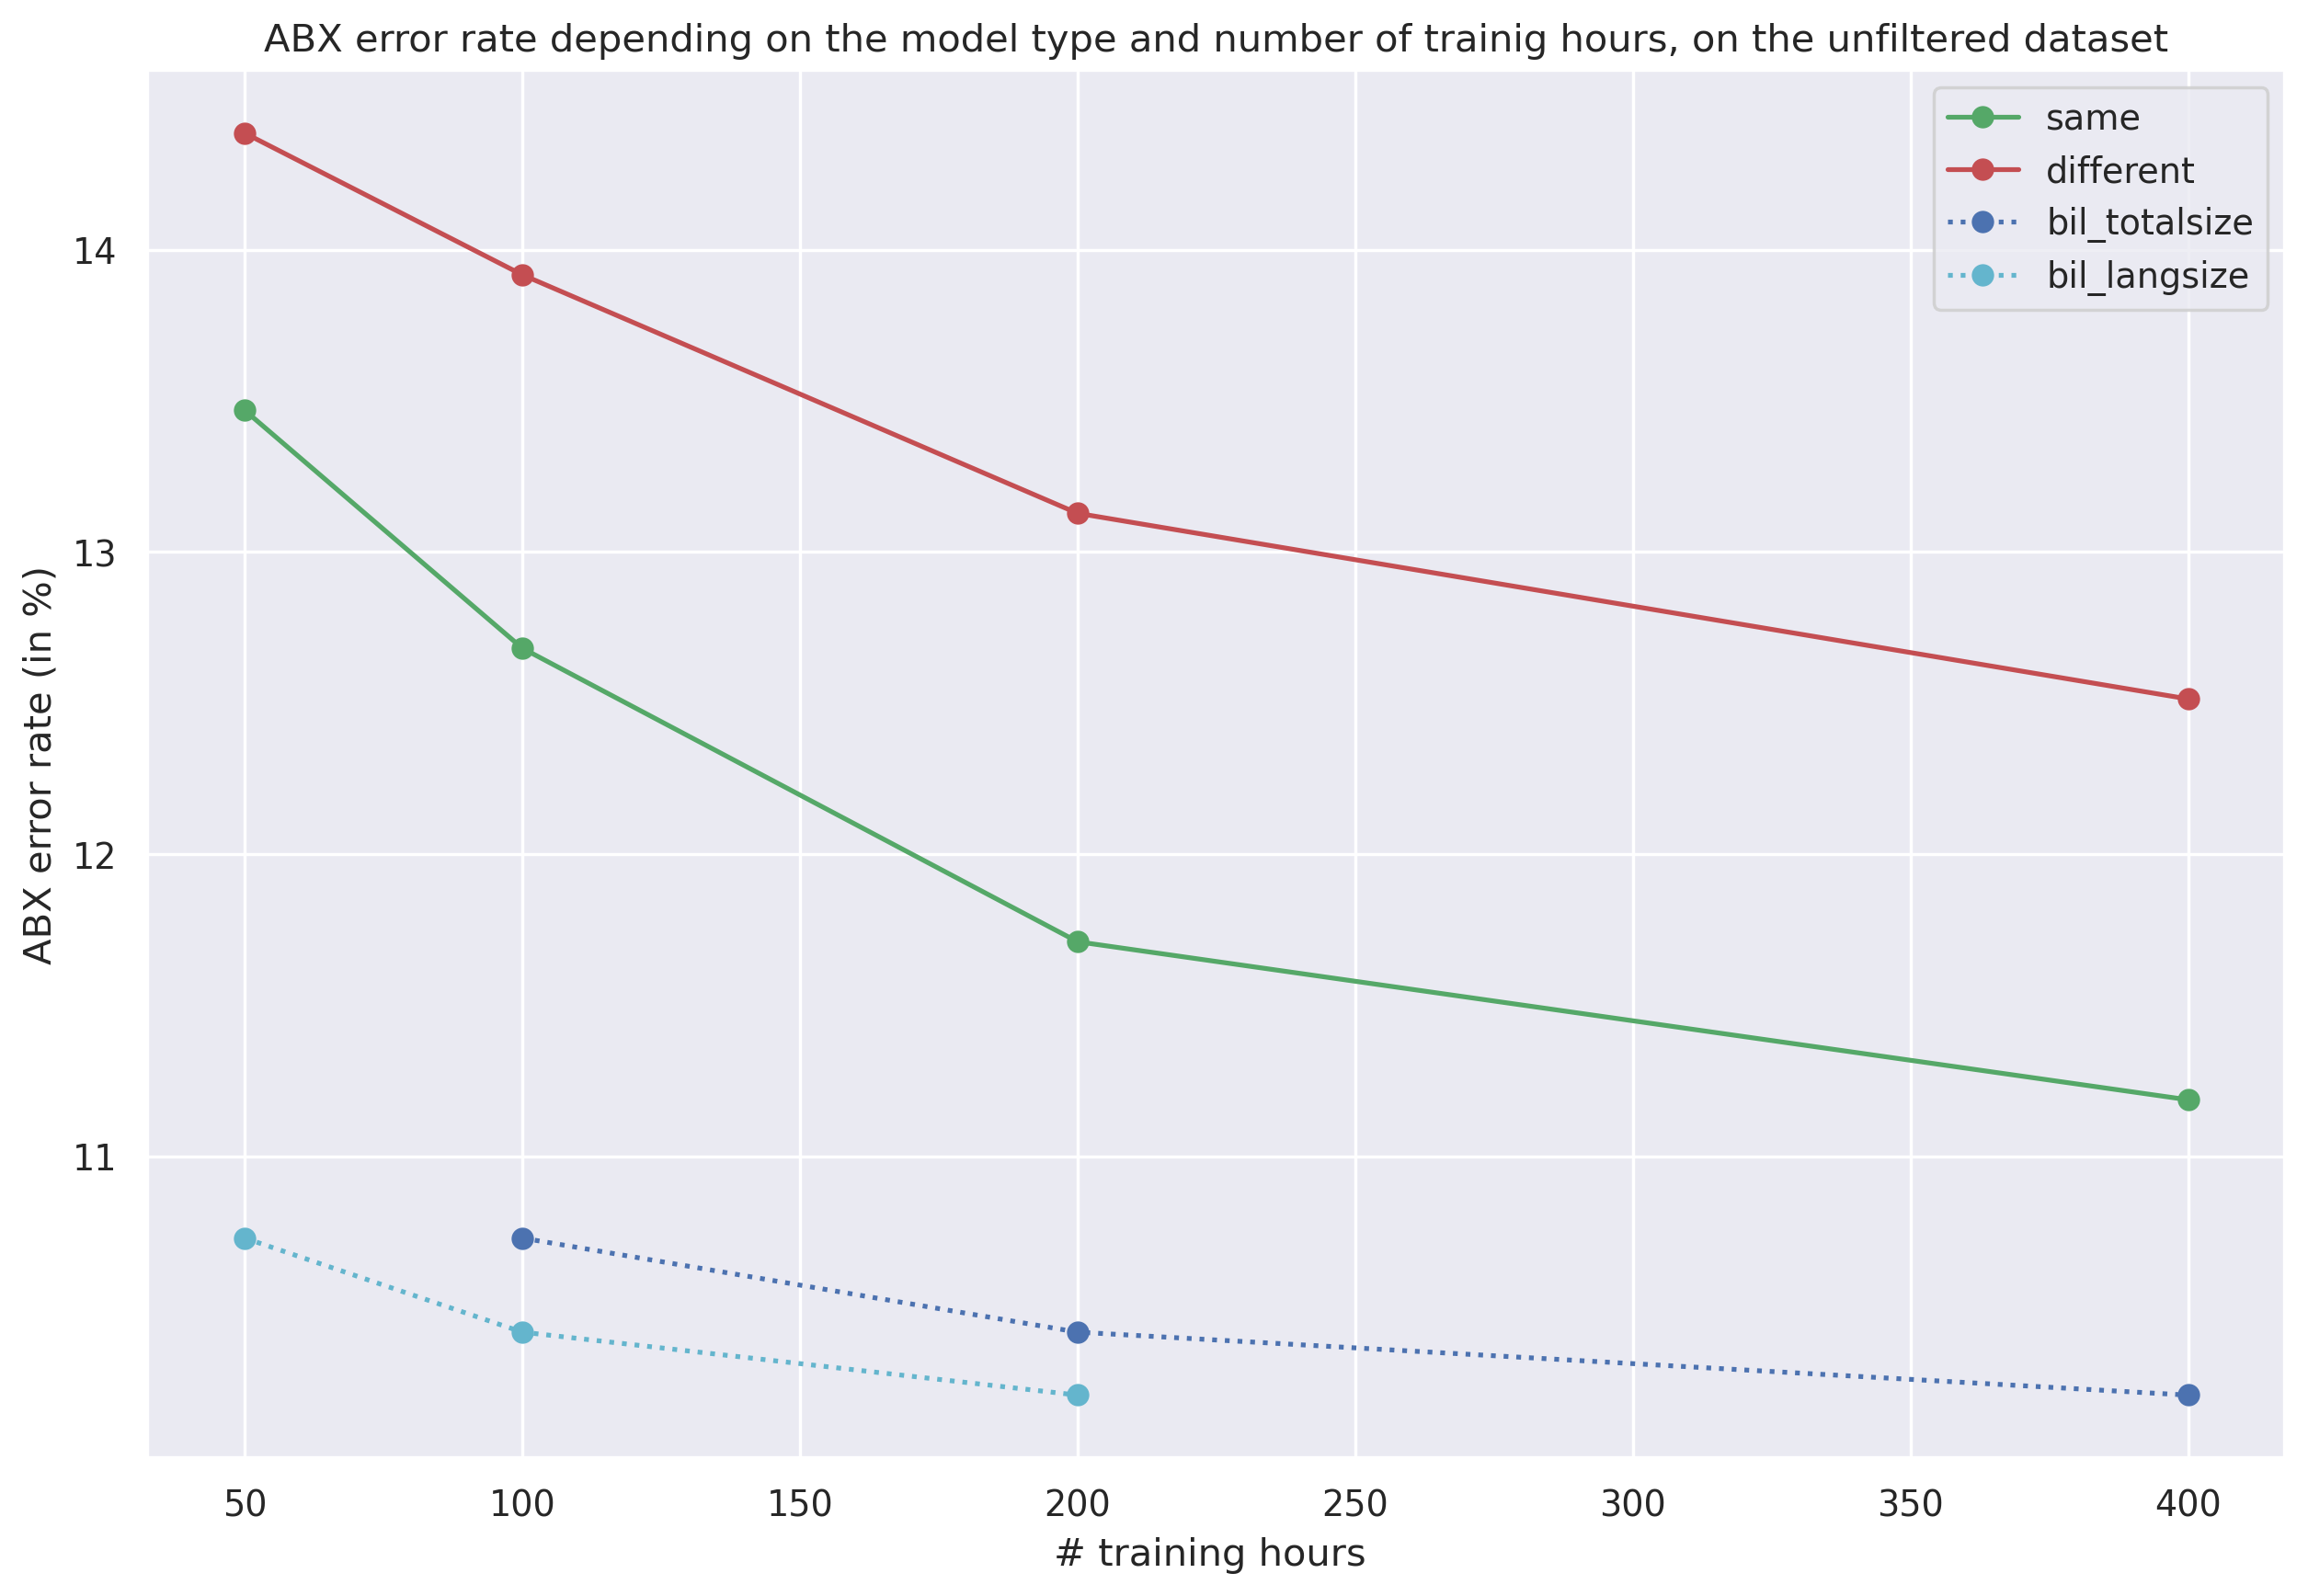

In [29]:
df_size[['same', 'different', 'bil_totalsize', 'bil_langsize']].plot(style = style_dict)
plt.xlabel('# training hours ')
plt.ylabel("ABX error rate (in %)")
plt.title("ABX error rate depending on the model type and number of trainig hours, on the unfiltered dataset")

Text(0.5, 1.0, 'ABX error rate depending on the model type and number of trainig hours, on the unfiltered dataset')

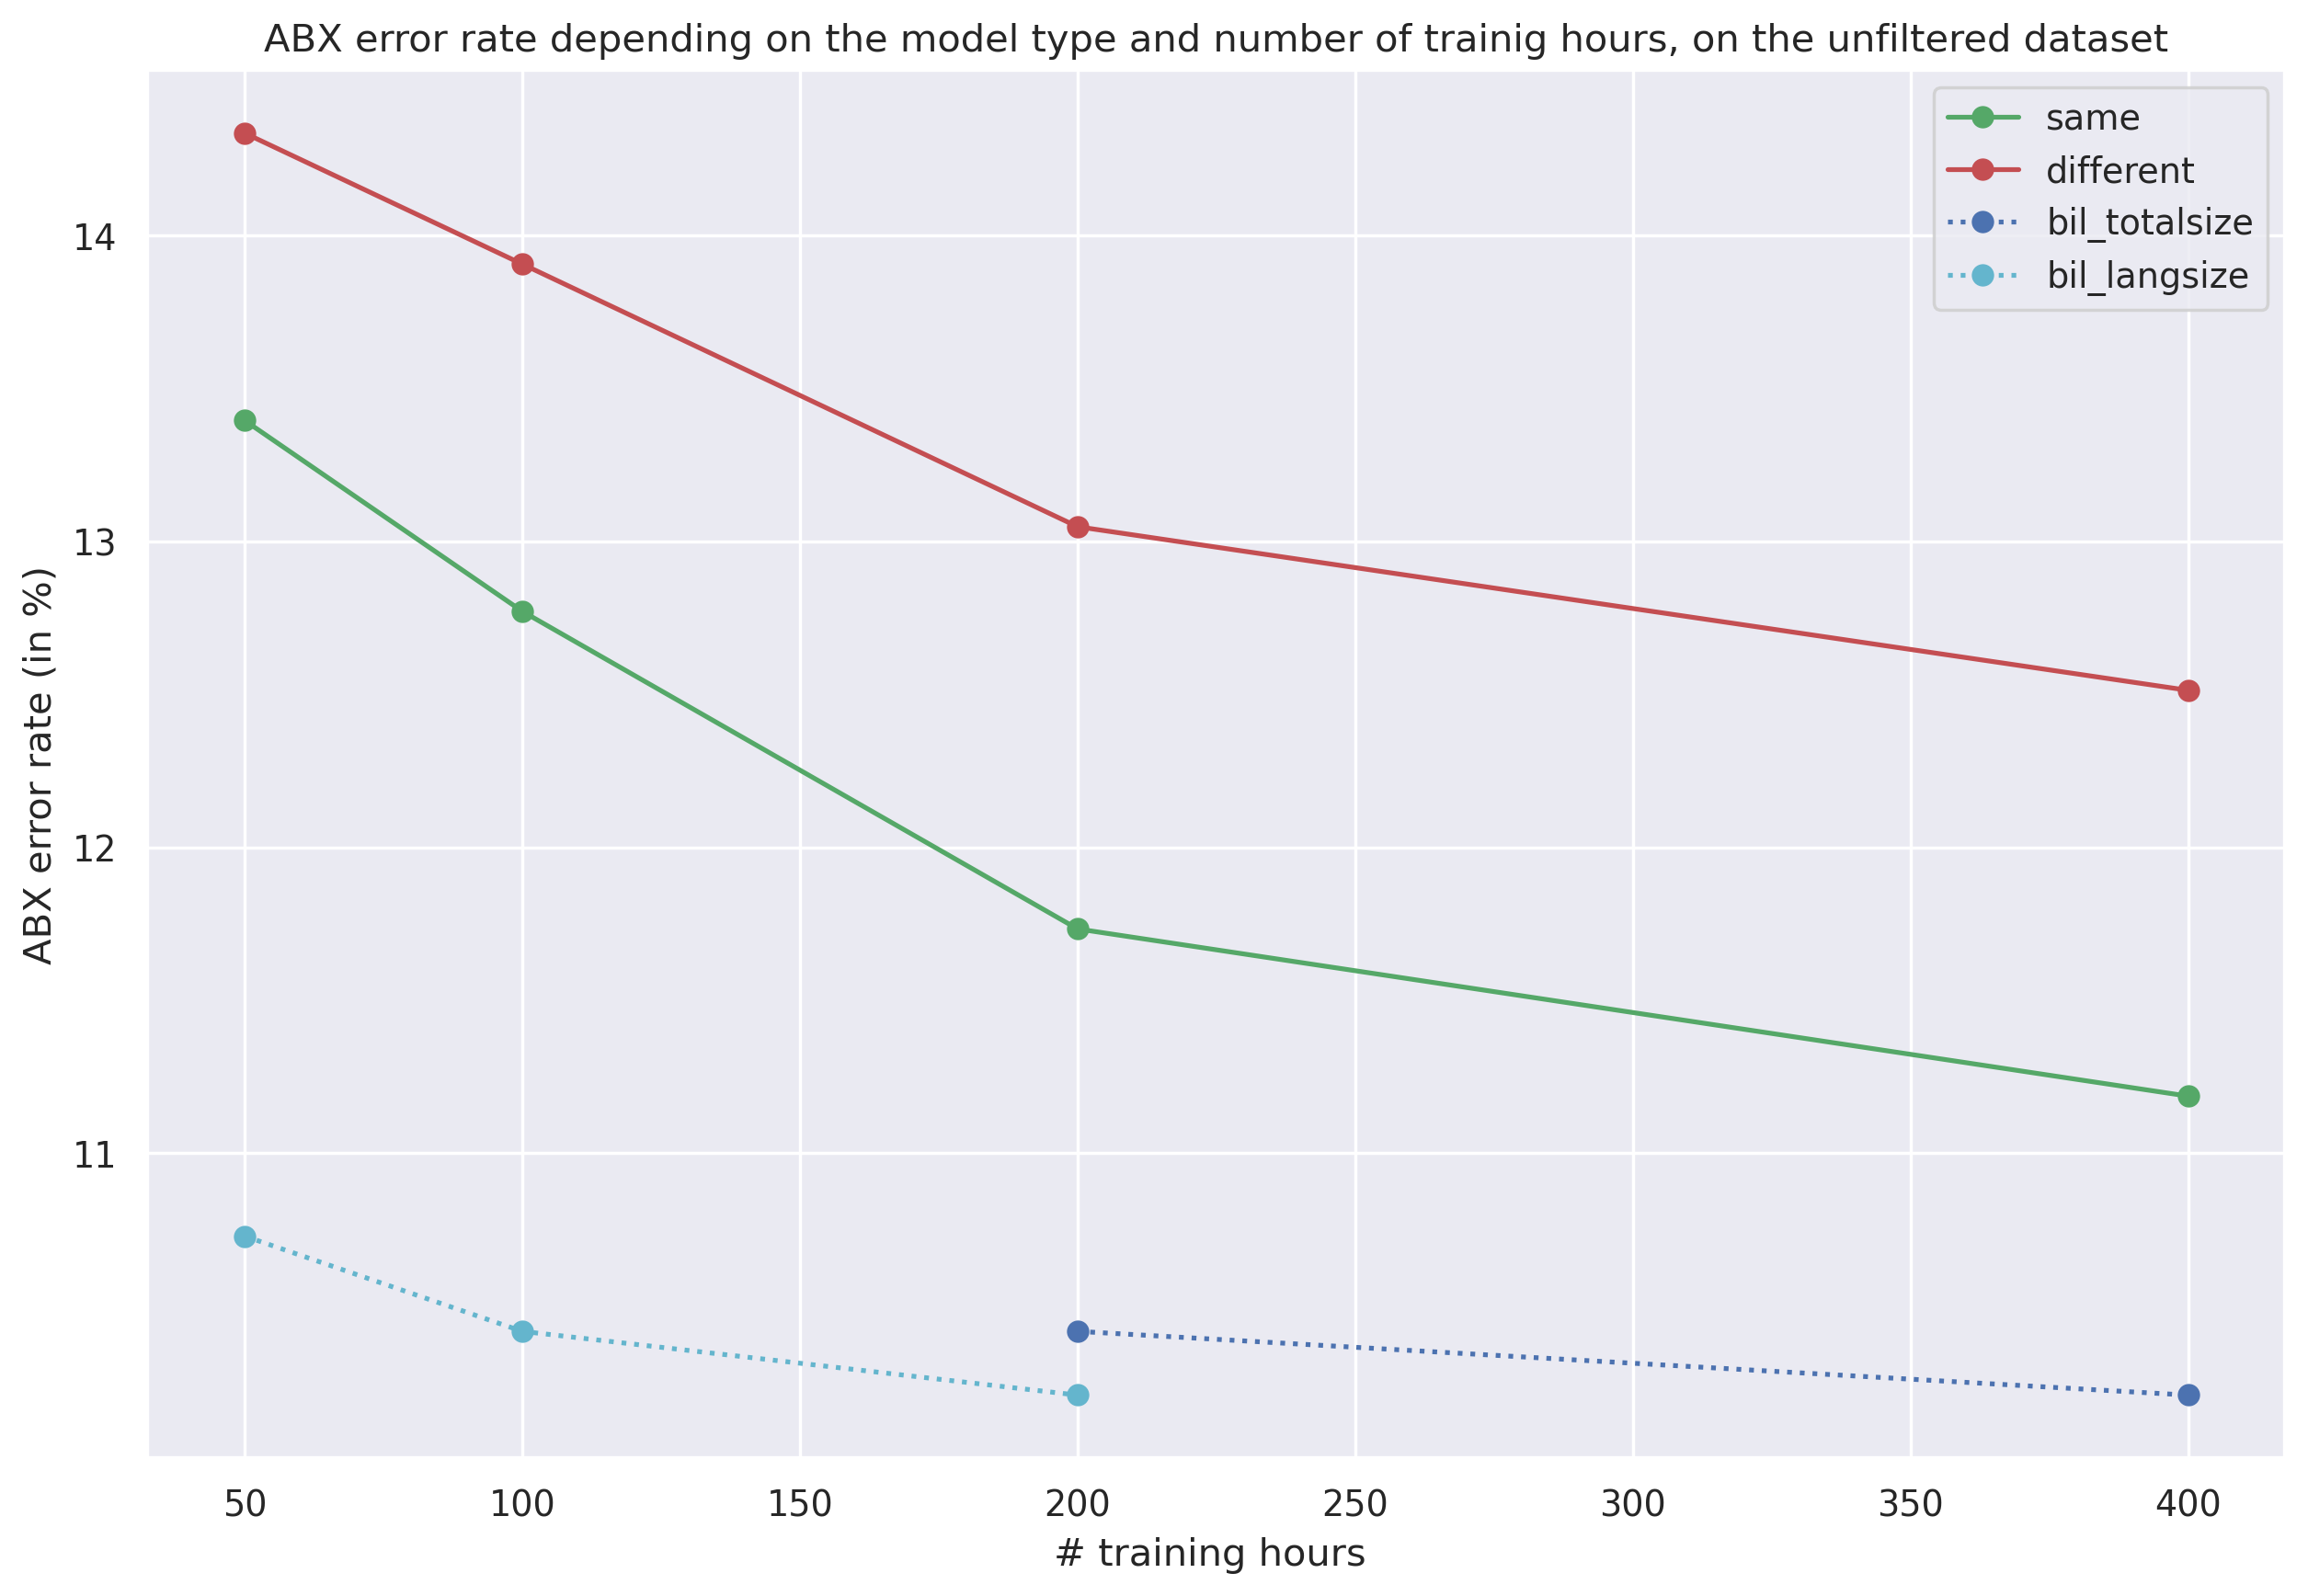

In [30]:
df_filt_size[['same', 'different', 'bil_totalsize', 'bil_langsize']].plot(style = style_dict)
plt.xlabel('# training hours ')
plt.ylabel("ABX error rate (in %)")
plt.title("ABX error rate depending on the model type and number of trainig hours, on the unfiltered dataset")

Text(0.5, 1.0, 'ABX error rate depending on the model type and number of trainig hours, on the unfiltered dataset')

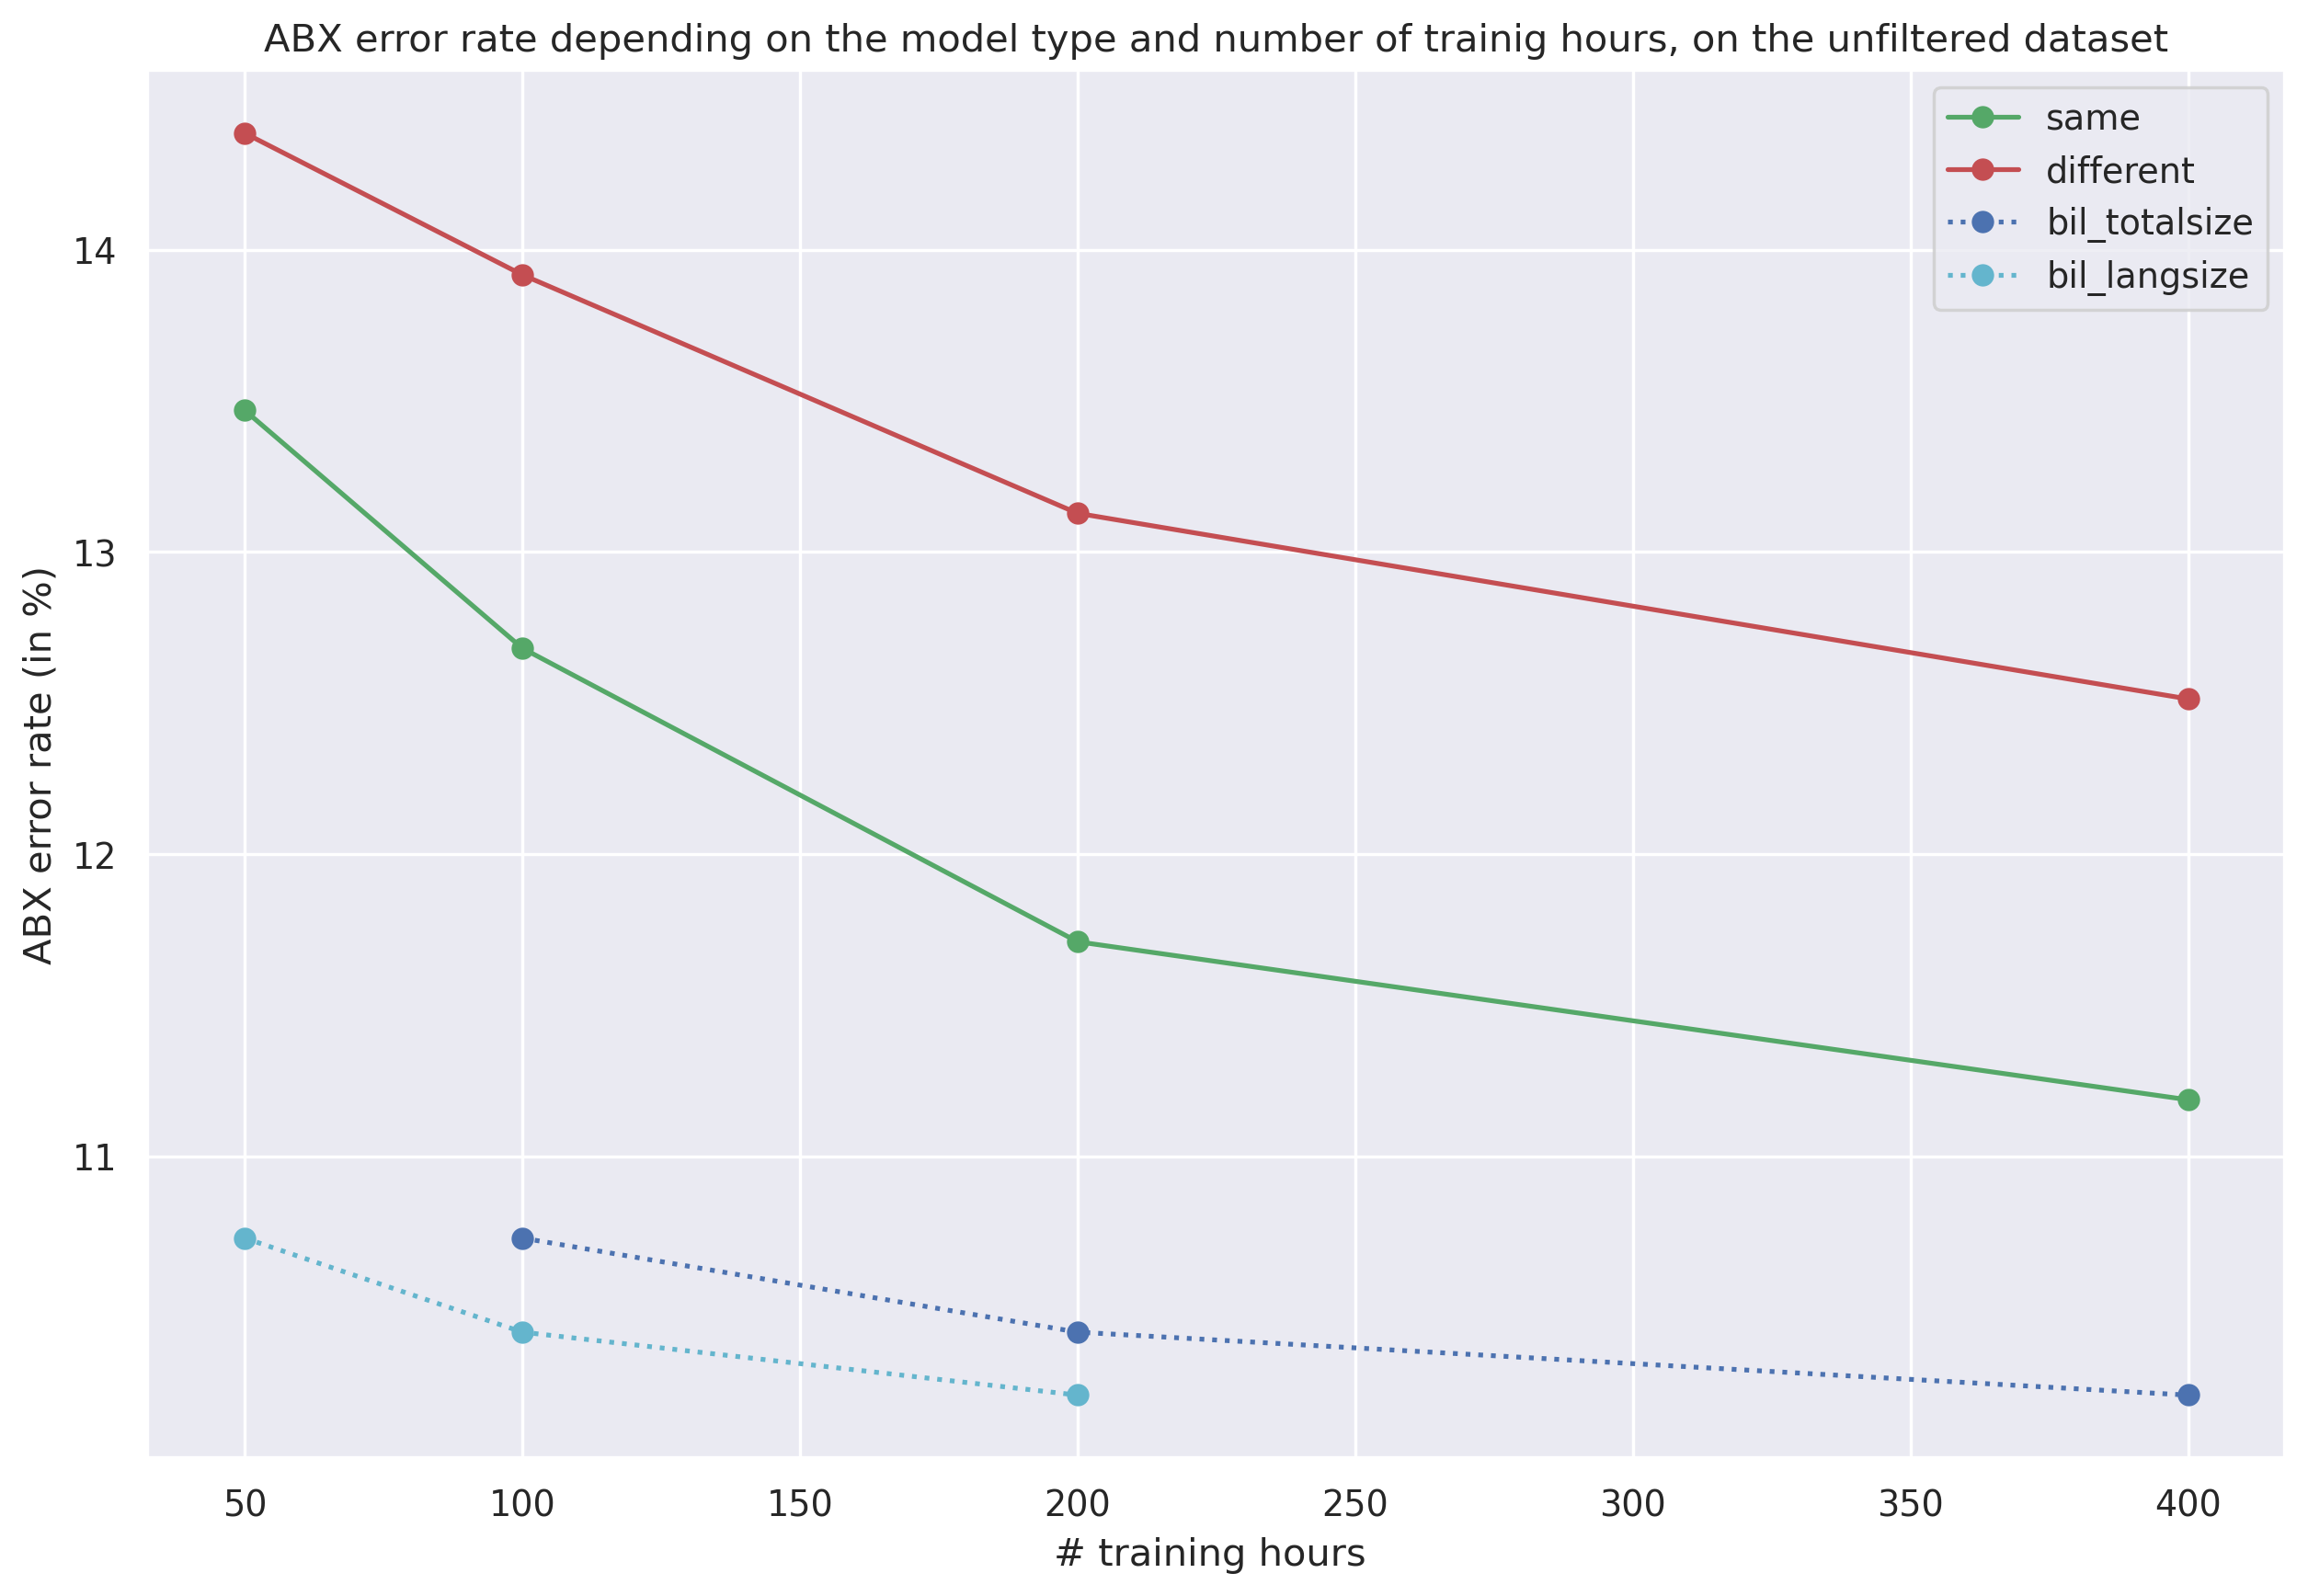

In [31]:
df_filt_strict_size[['same', 'different', 'bil_totalsize', 'bil_langsize']].plot(style = style_dict)
plt.xlabel('# training hours ')
plt.ylabel("ABX error rate (in %)")
plt.title("ABX error rate depending on the model type and number of trainig hours, on the unfiltered dataset")

In [32]:

style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--'}

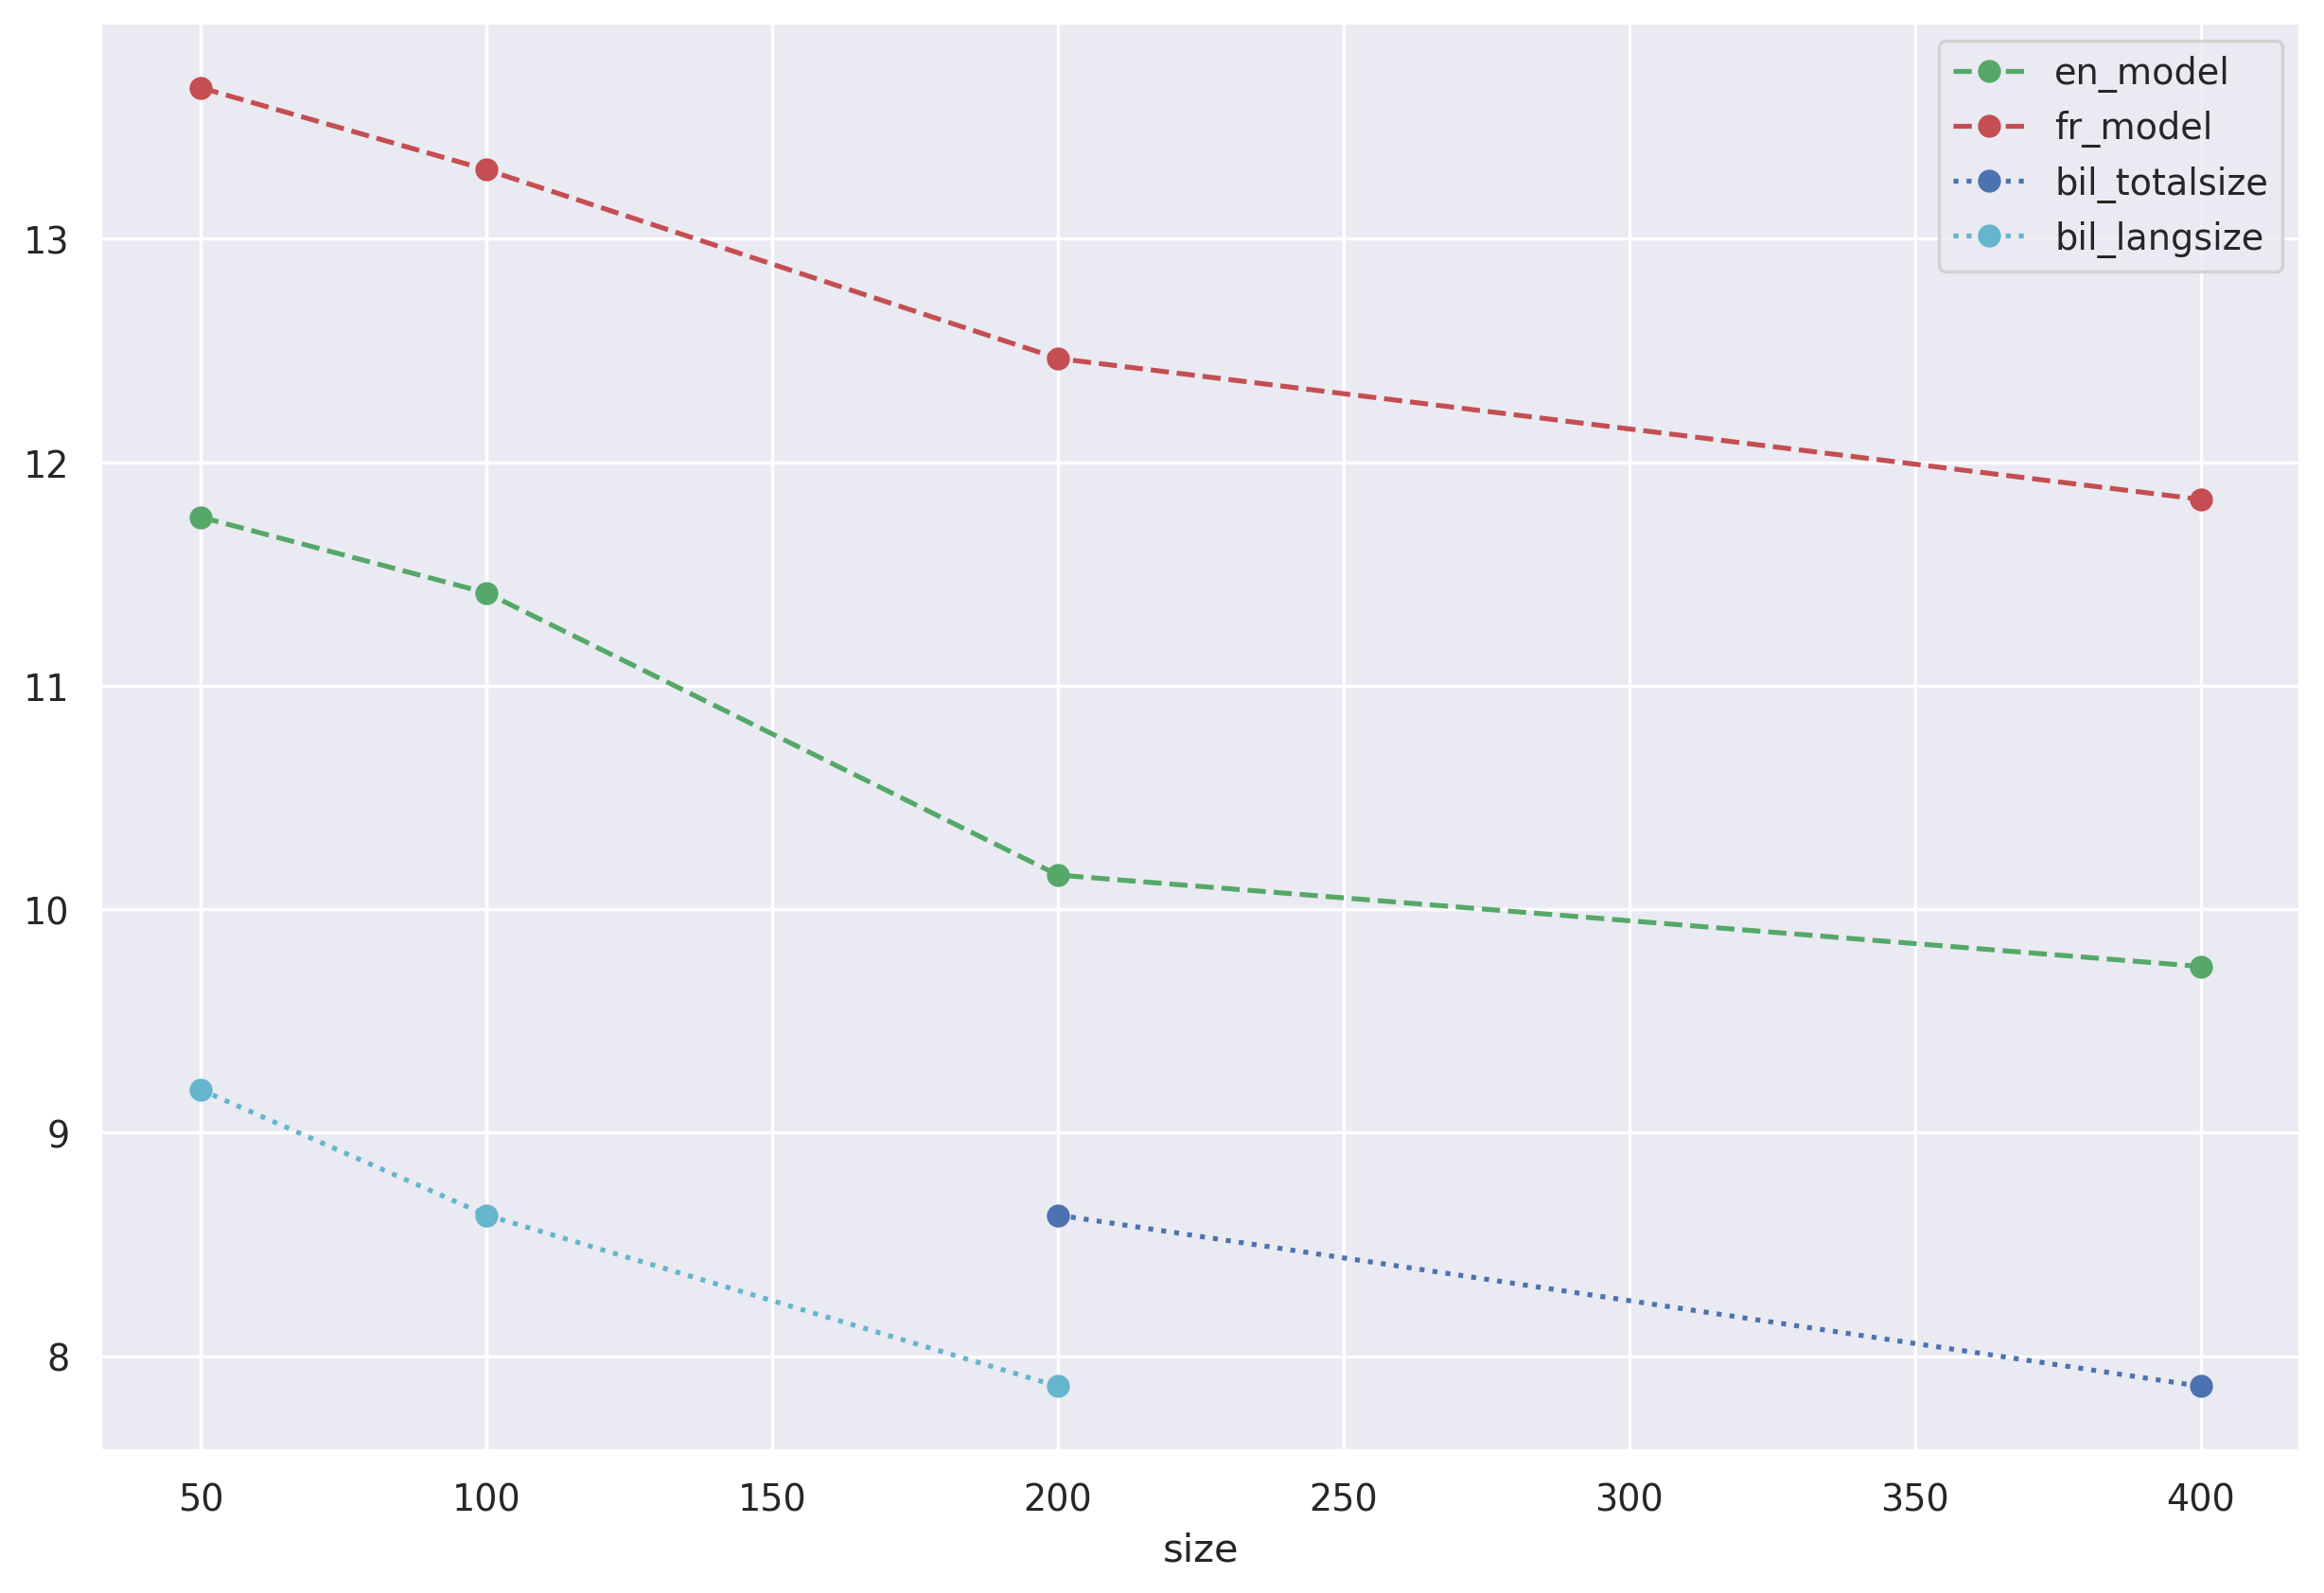

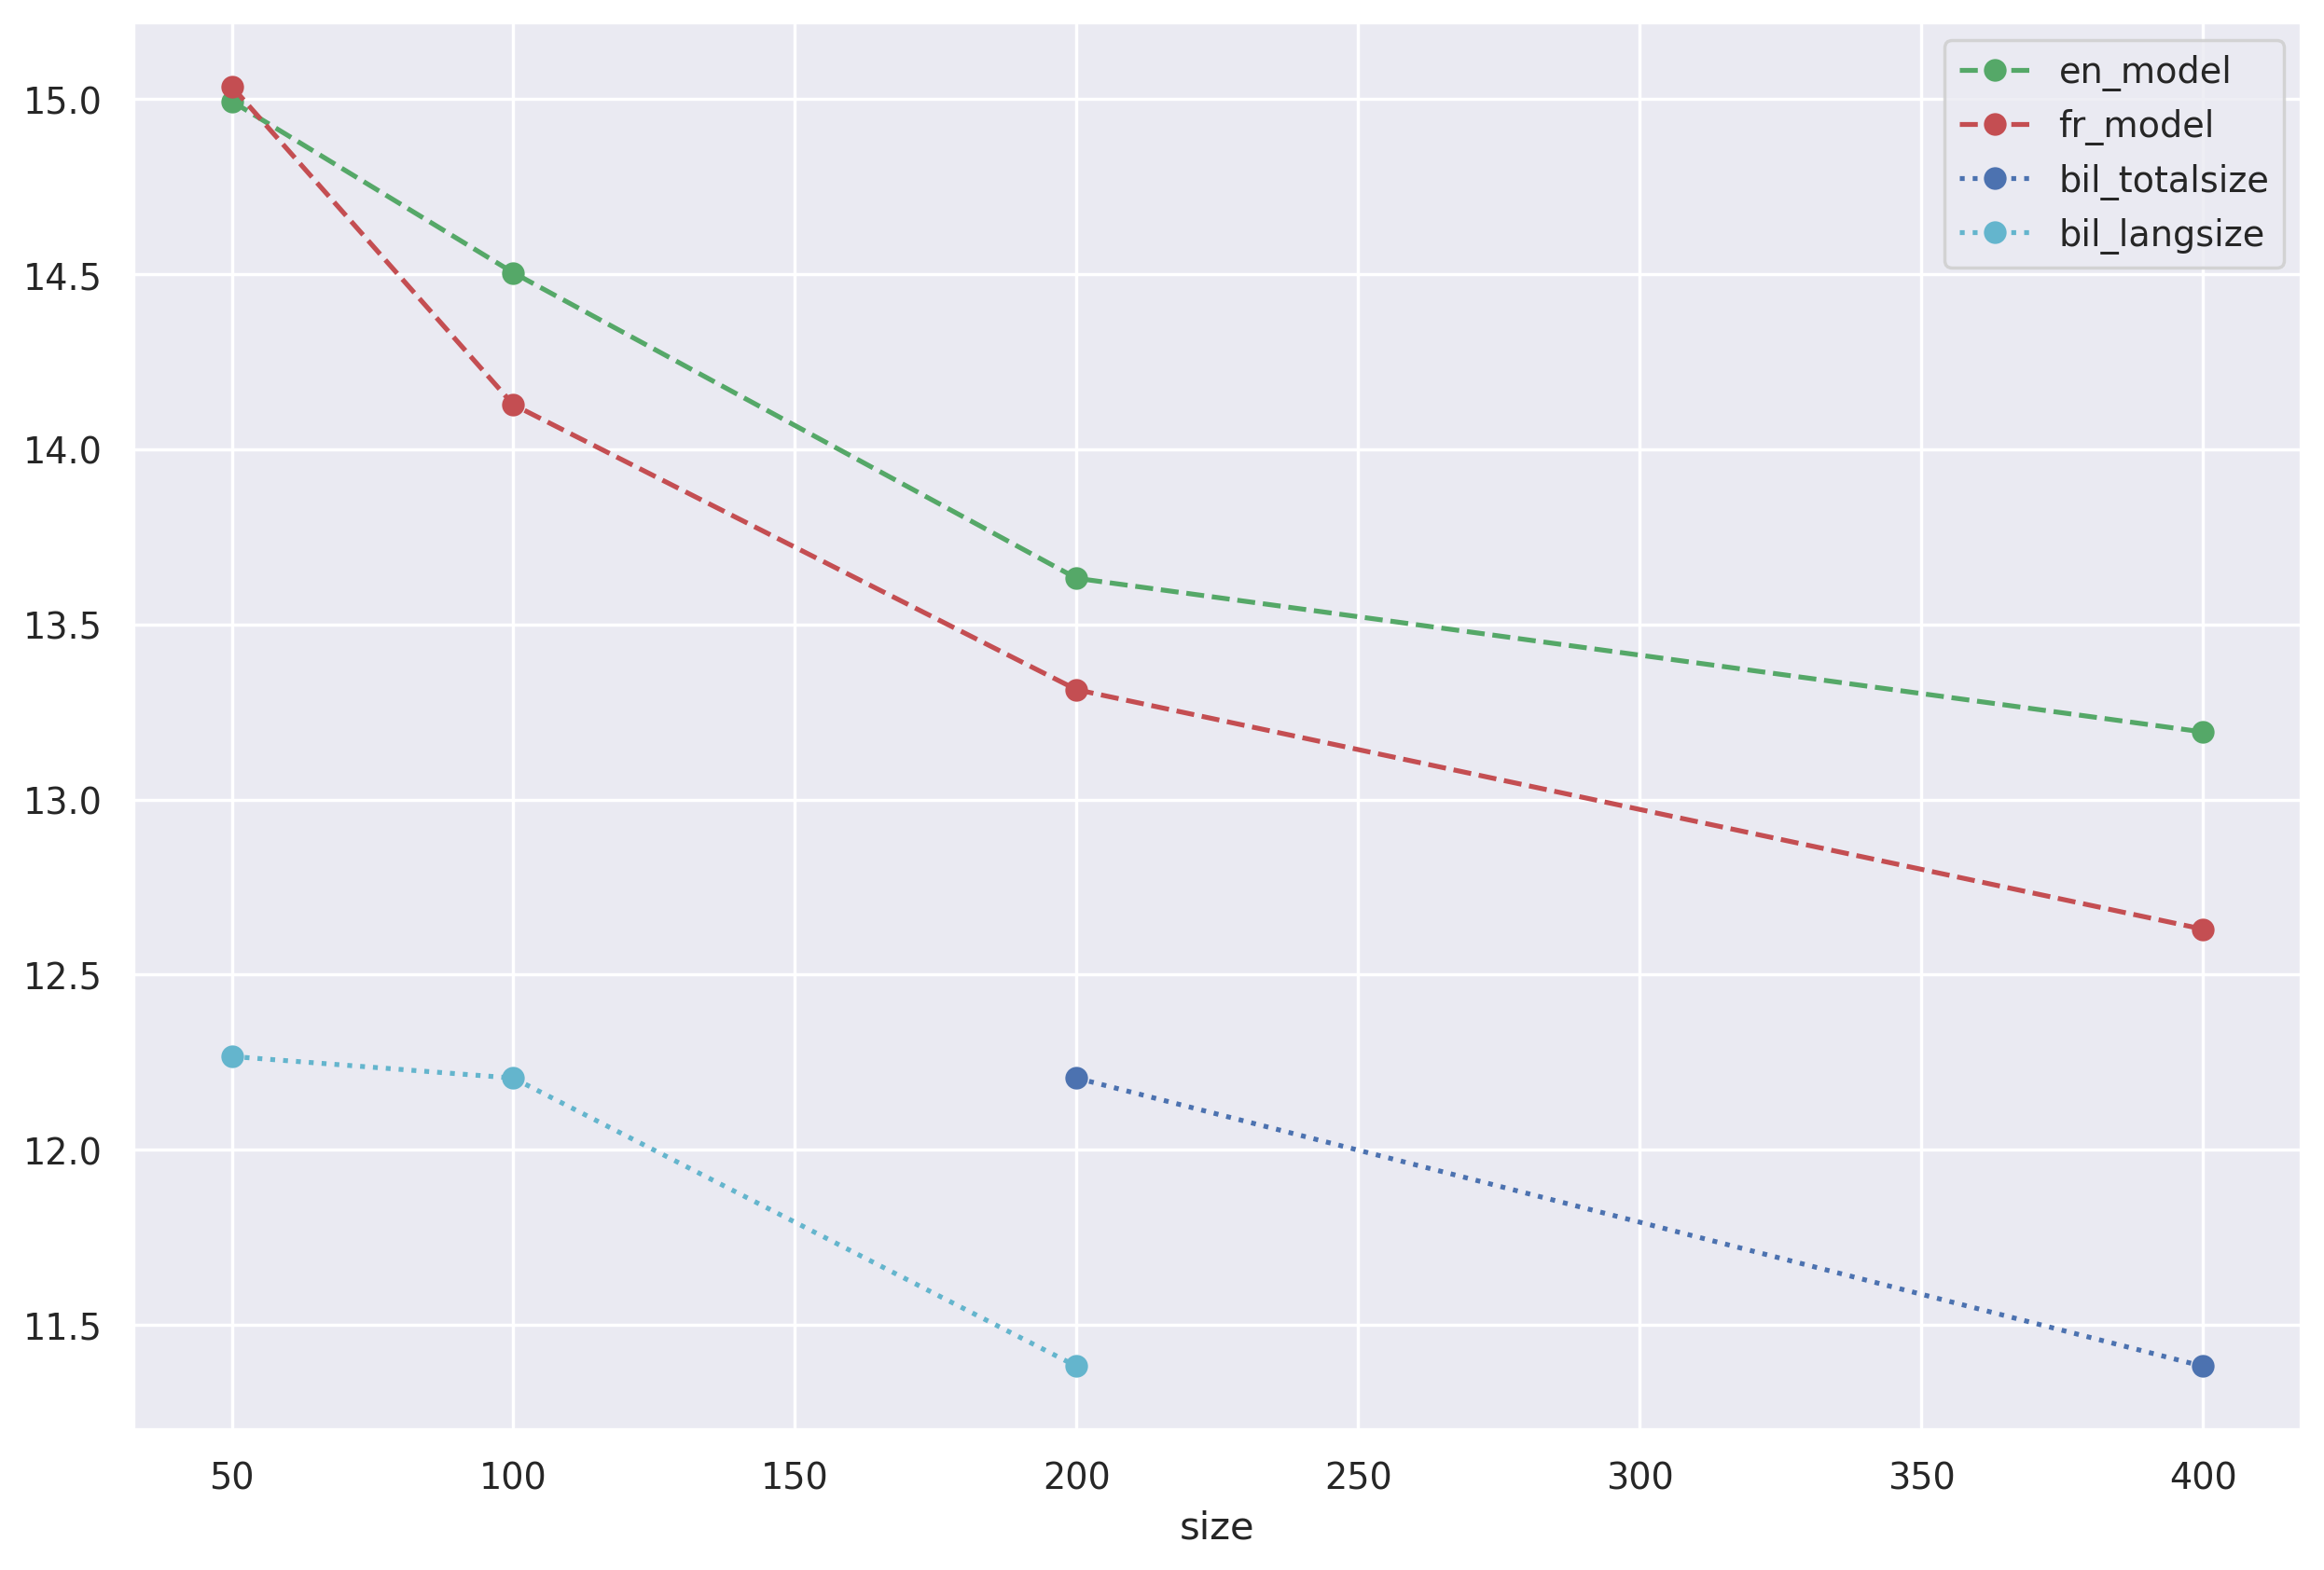

In [33]:
#fig, axes = plt.subplots(nrows=1, ncols=2)

for l in ["english", "french"]:
    df_tmp = df_filt[df_filt["eval_lang"]==l].groupby(by="size").mean()
    #df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize']].plot(style = style_dict)
    df_tmp = df_tmp[['en_model', 'fr_model', 'bil_totalsize', 'bil_langsize']].plot(style = style_dict)

<AxesSubplot:xlabel='size'>

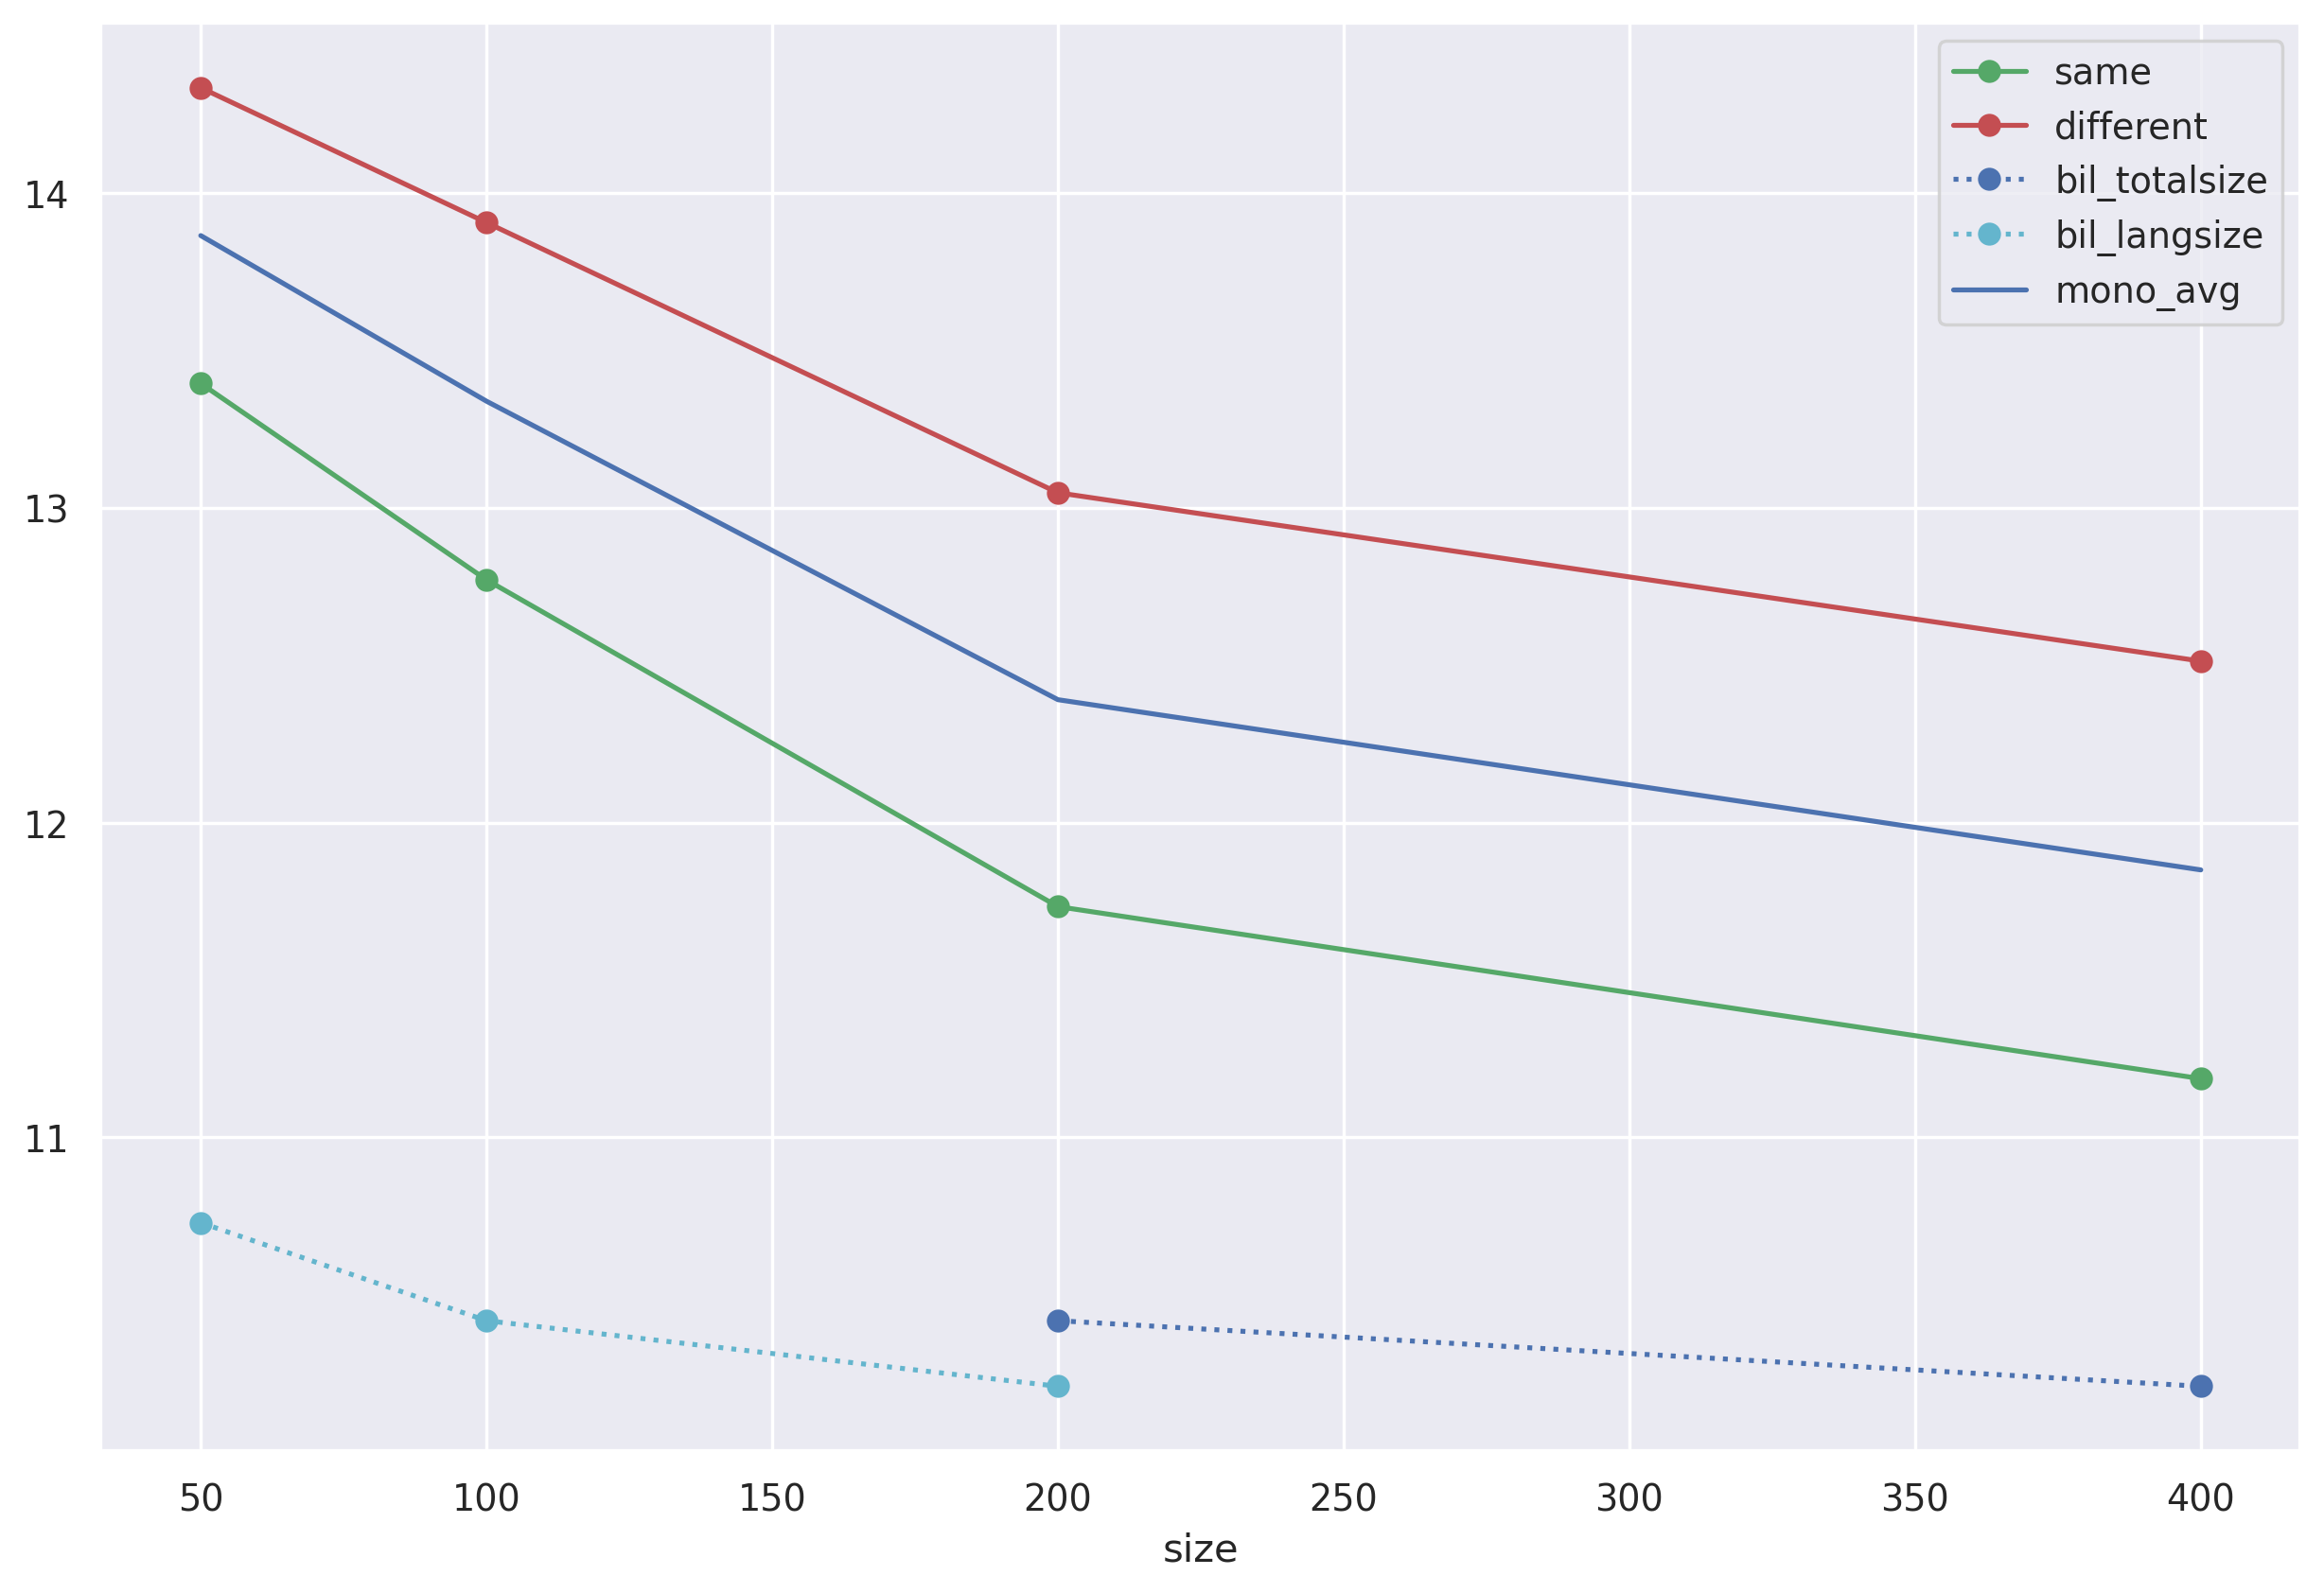

In [34]:
df_filt_size[['same', 'different',  'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)

<AxesSubplot:xlabel='size'>

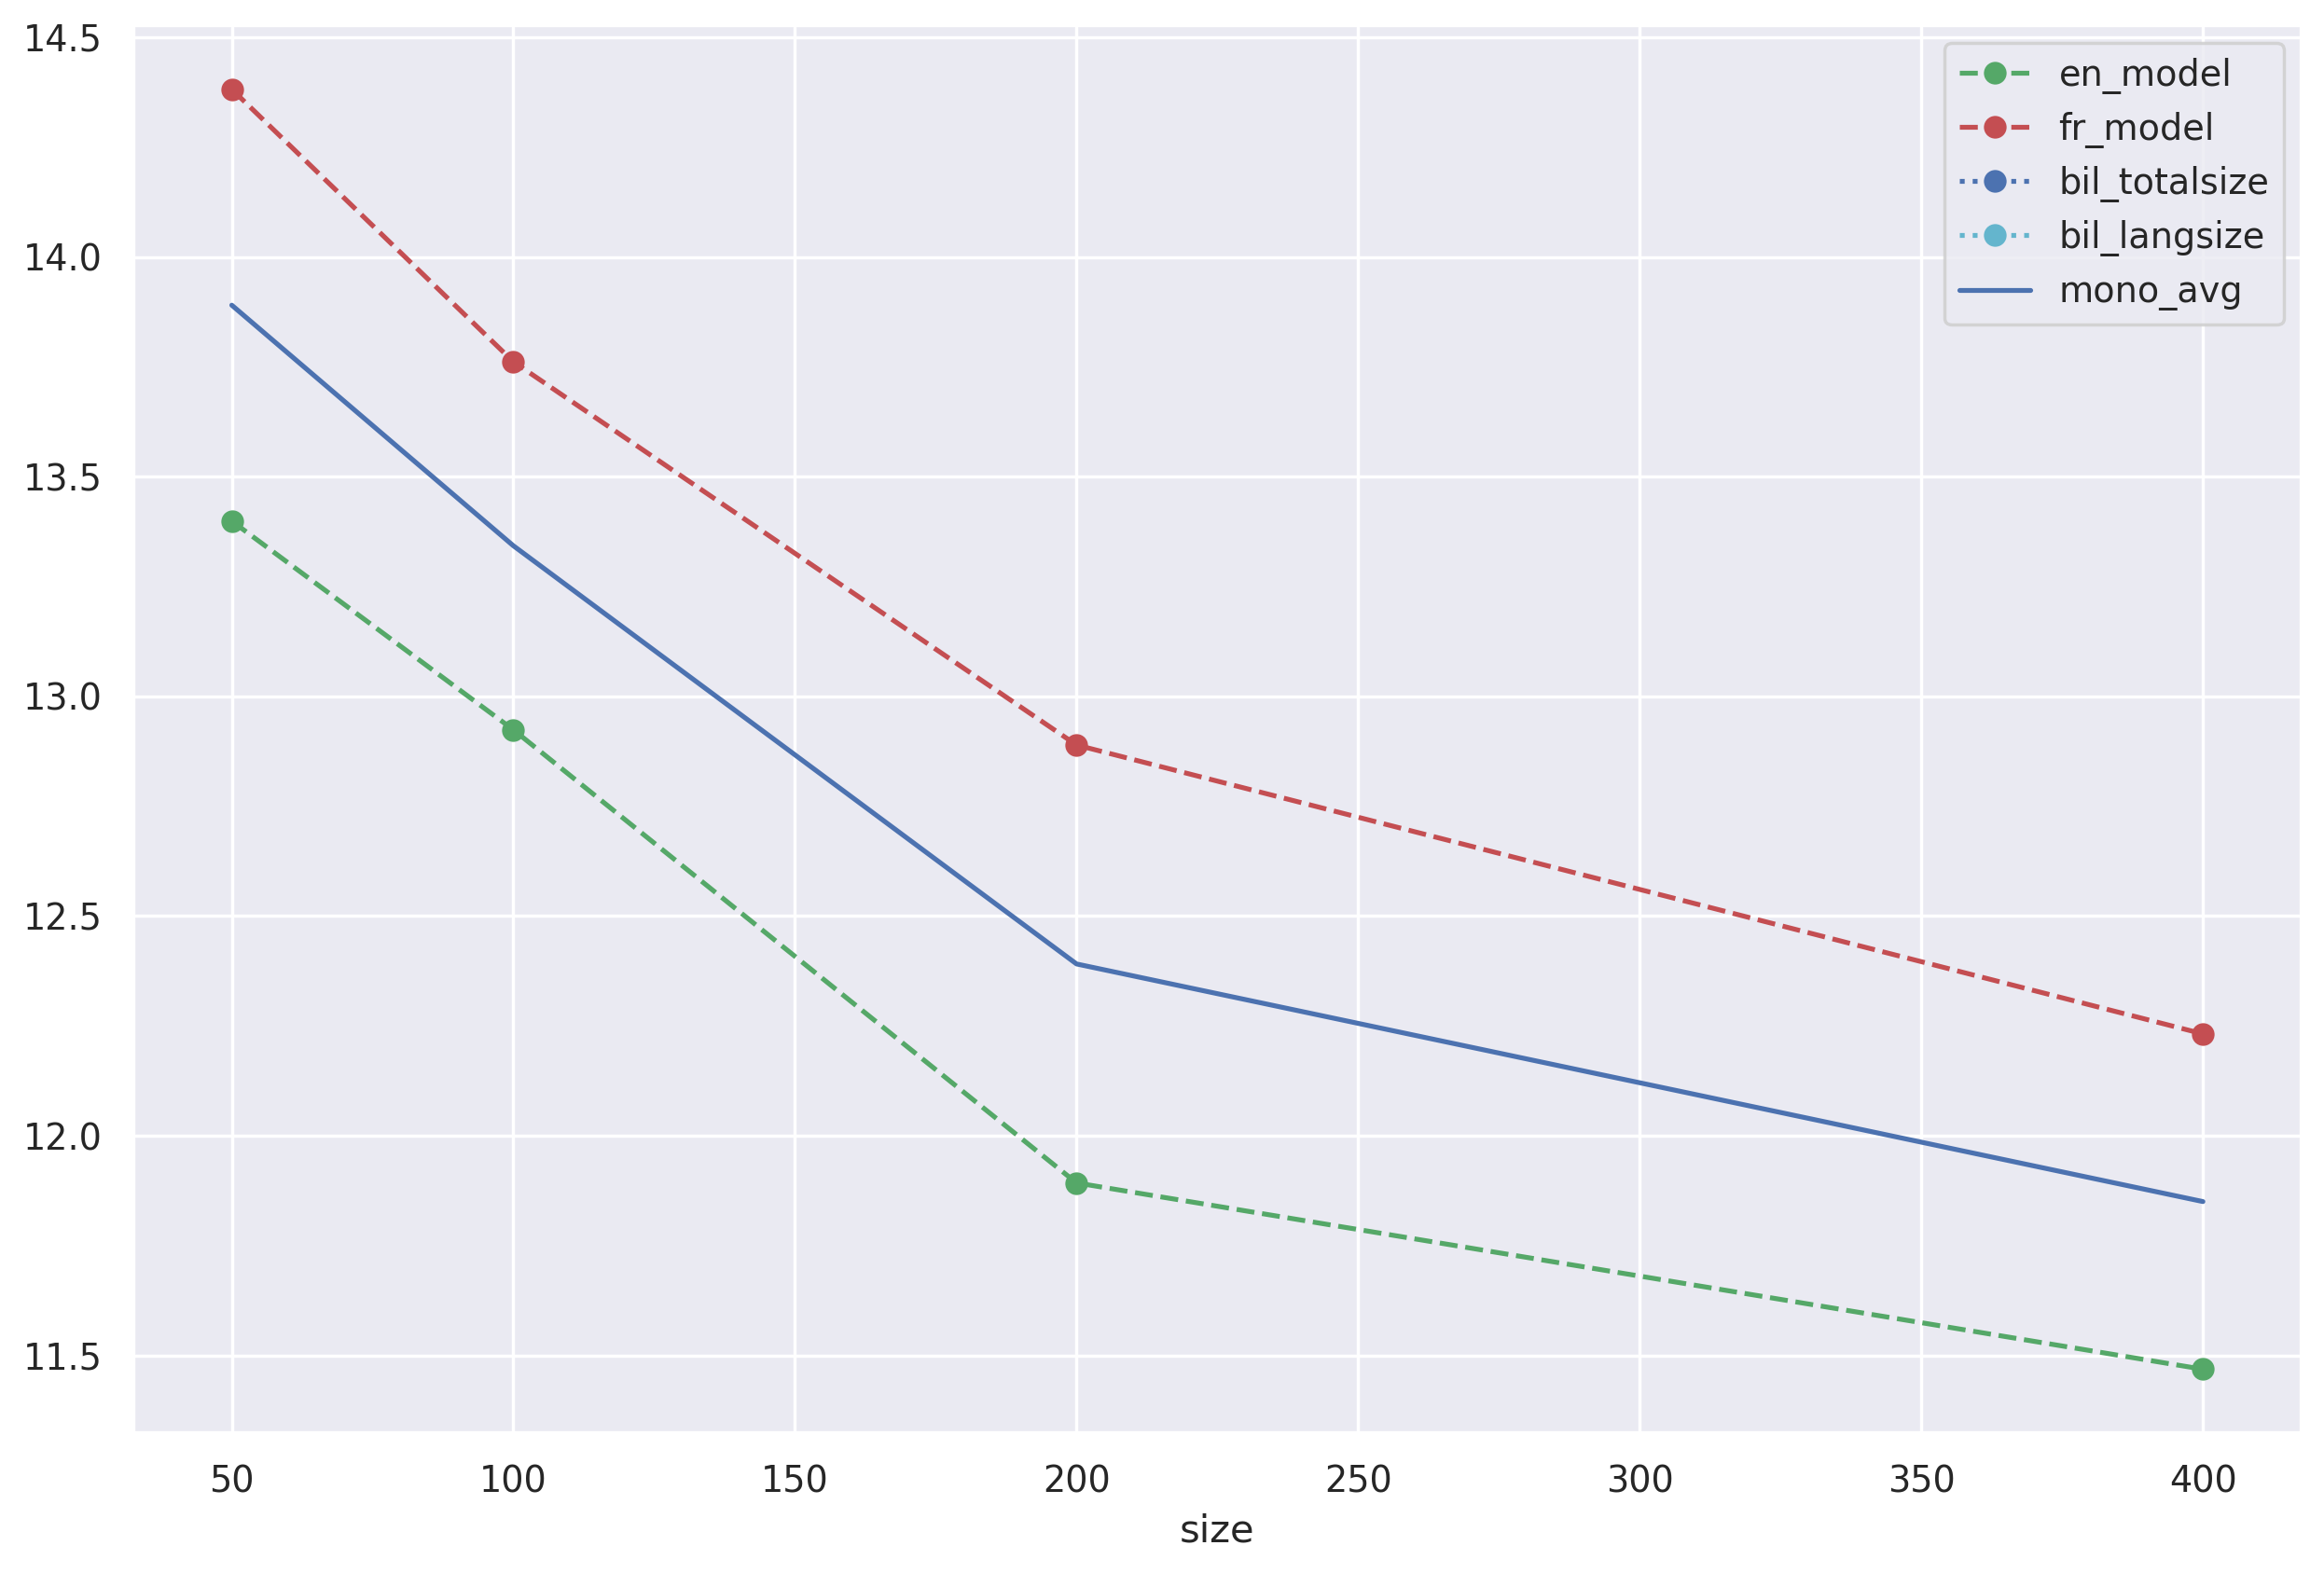

In [120]:
df_filt_size[['en_model', 'fr_model',  'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)

<AxesSubplot:xlabel='size'>

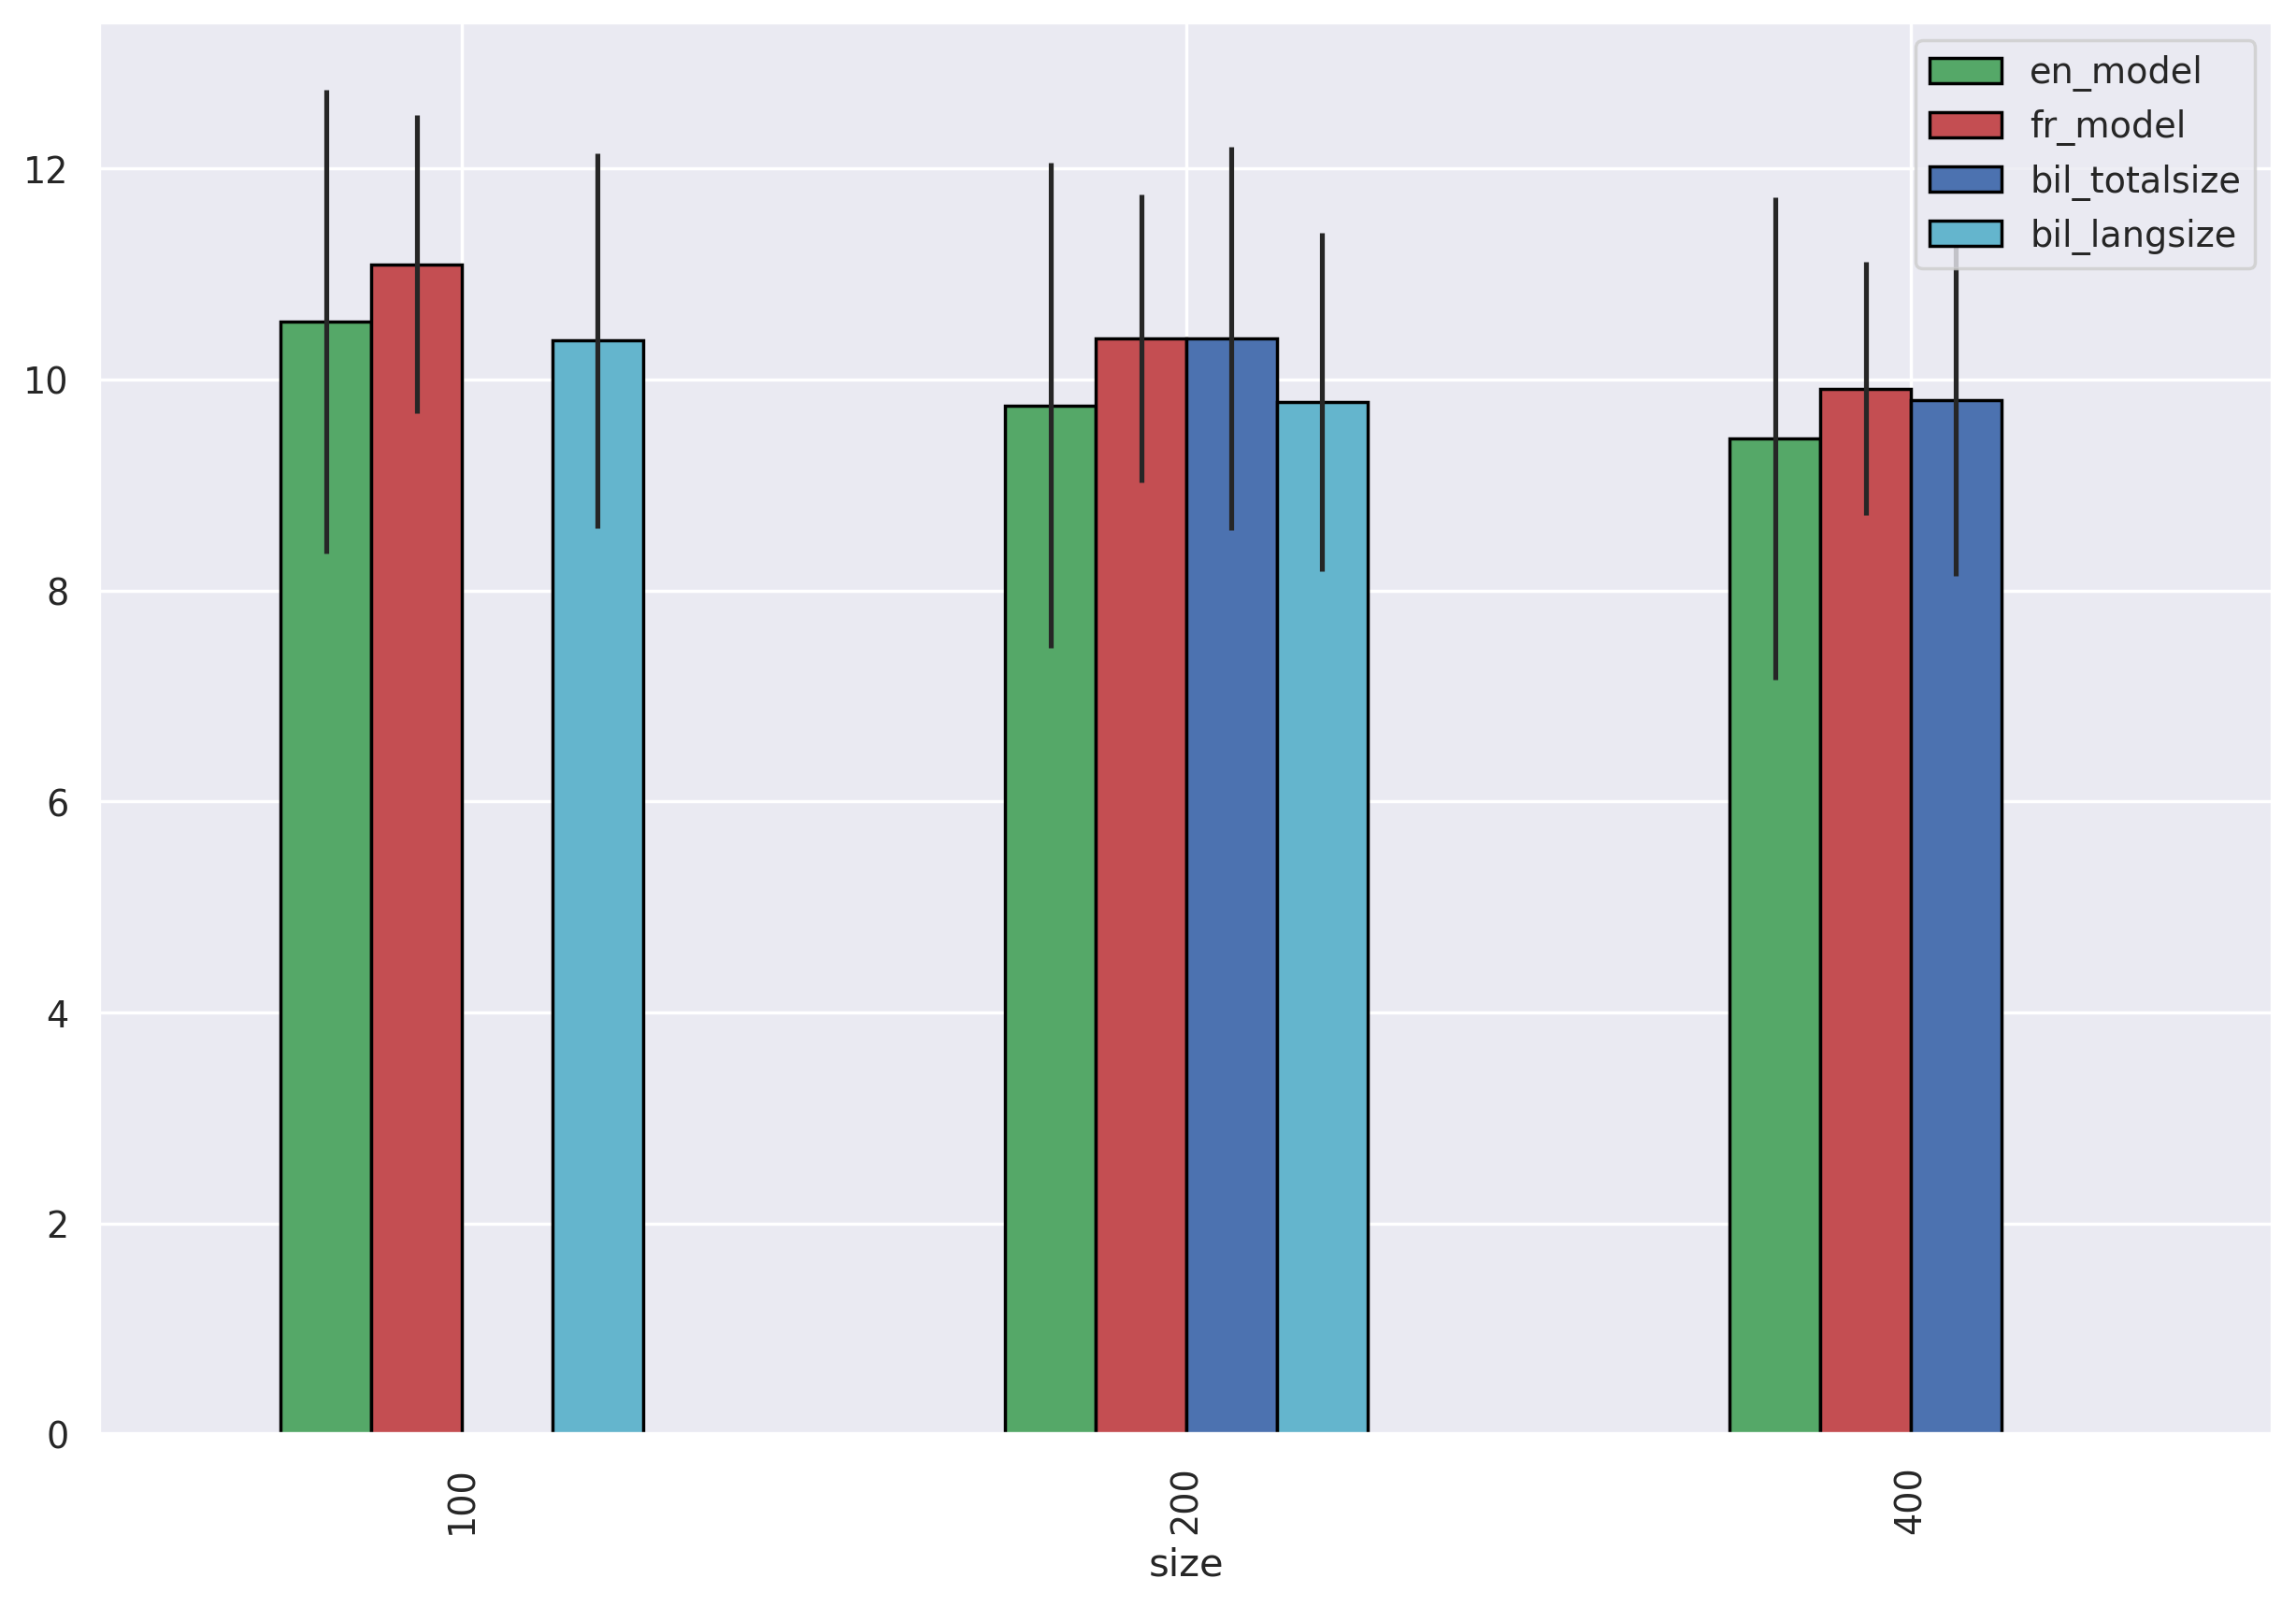

In [21]:
df_filt_size[['en_model', 'fr_model',  'bil_totalsize', 'bil_langsize']].plot.bar(color= ['g', 'r', 'b', 'c'], ec="black", yerr=df_filt.groupby(by="size").std()
)

<AxesSubplot:xlabel='size'>

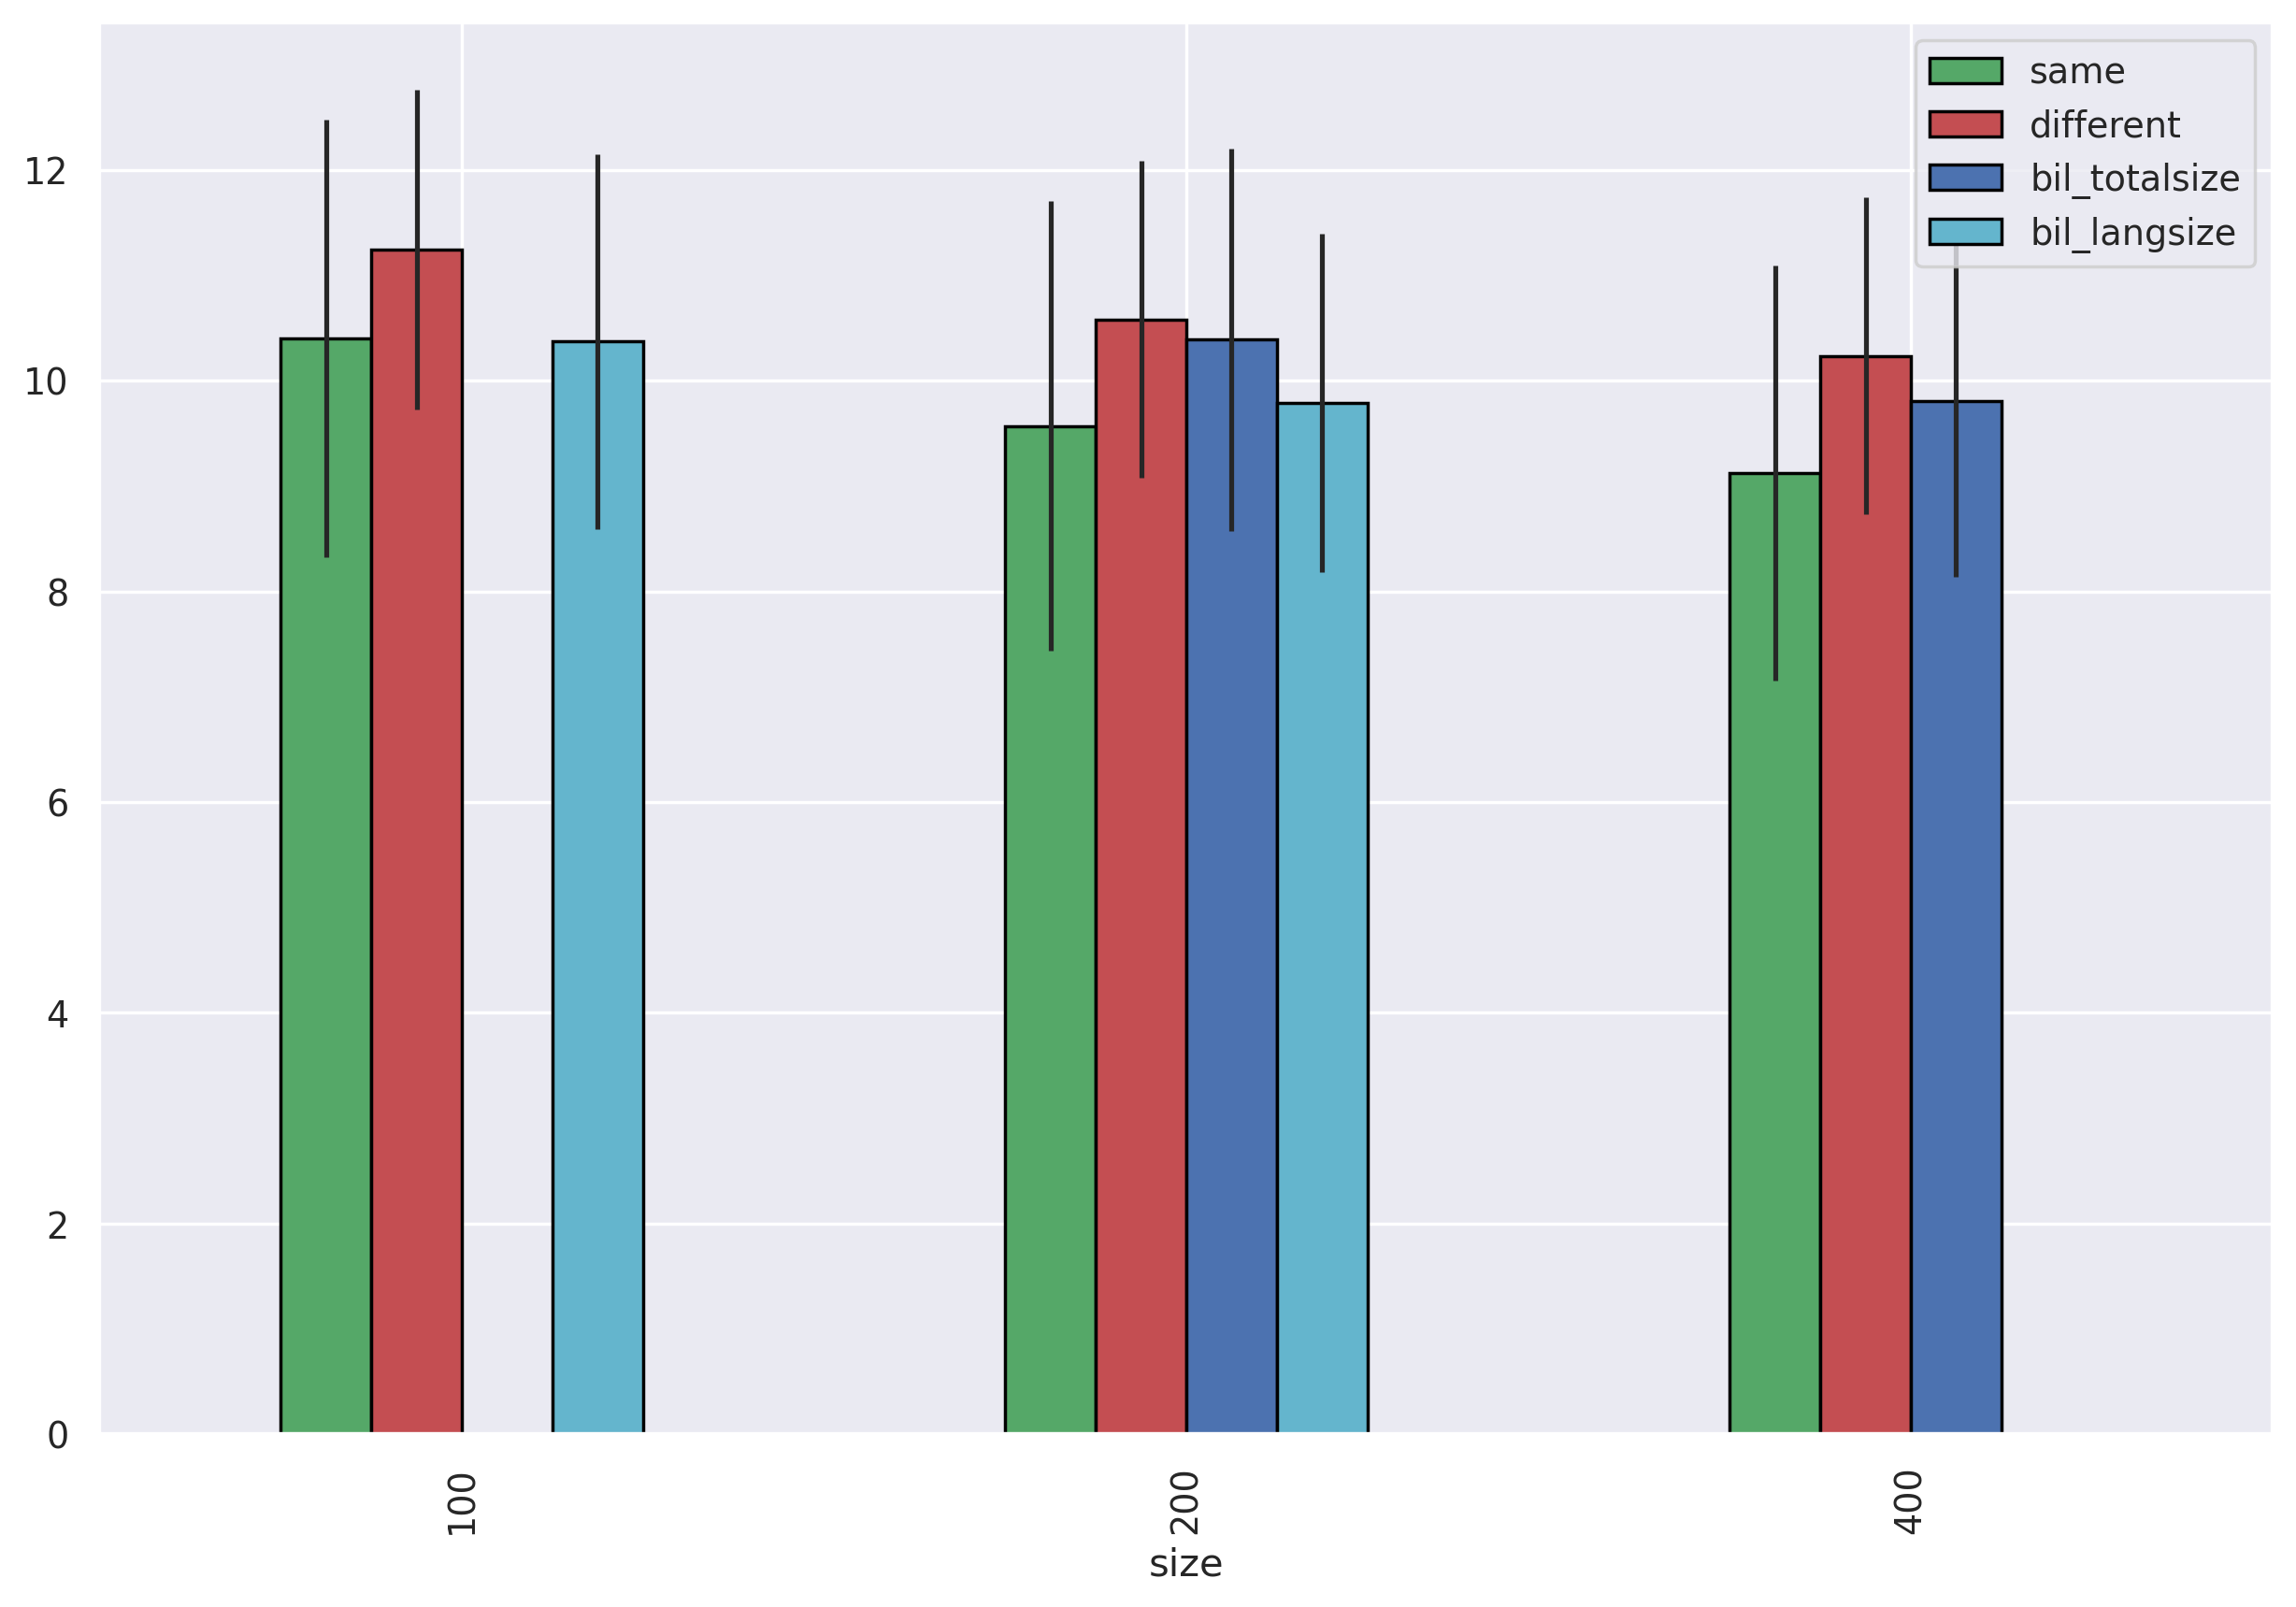

In [22]:
df_filt_size[['same', 'different',  'bil_totalsize', 'bil_langsize']].plot.bar(color= ['g', 'r', 'b', 'c'], ec="black",yerr=df_filt.groupby(by="size").std()
 )

<AxesSubplot:xlabel='size'>

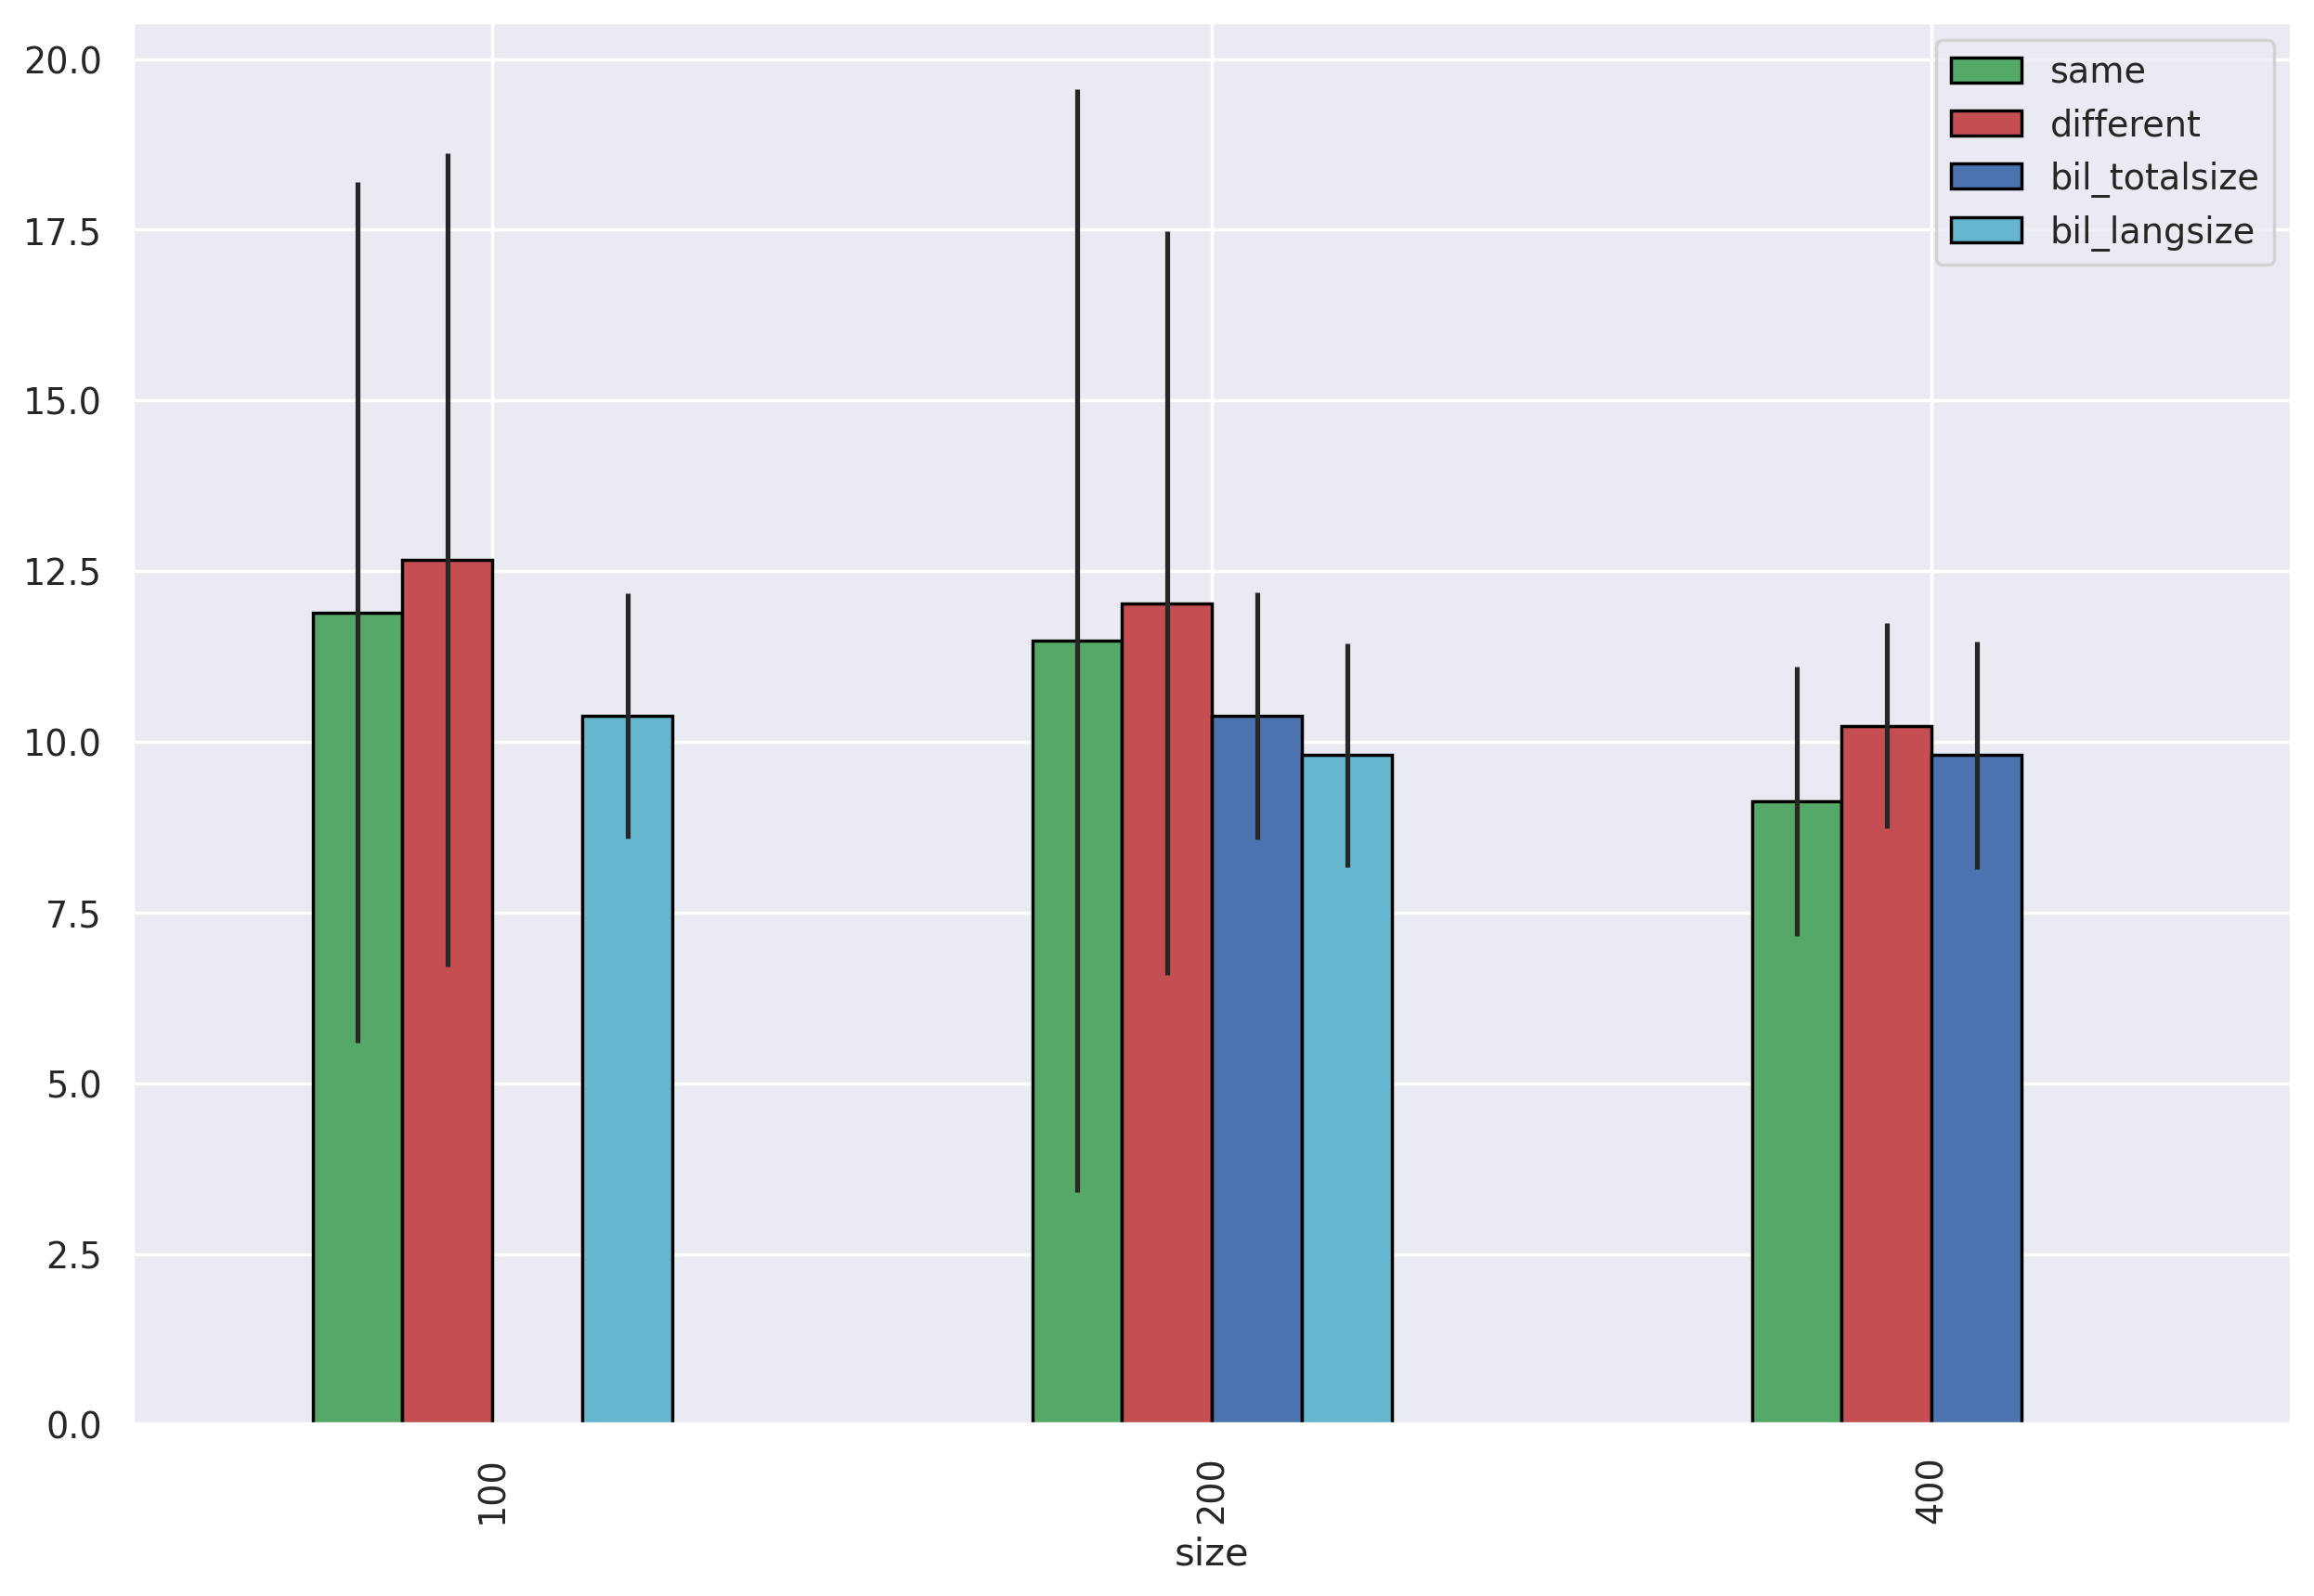

In [23]:
df_size[['same', 'different',  'bil_totalsize', 'bil_langsize']].plot.bar(color= ['g', 'r', 'b', 'c'], ec="black", yerr=df.groupby(by="size").std()
)

In [24]:
df_filt_size

,en_model,fr_model,bil_totalsize,same,different,bil_langsize,mono_avg
size,,,,,,,
100,10.547547,11.094641,NaN,10.402387,11.239800,10.370750,10.821094
200,9.754955,10.390571,10.388709,9.567031,10.578495,9.786587,10.072763
400,9.442970,9.916283,9.804259,9.124924,10.234329,NaN,9.679627


In [25]:
df_size

,en_model,fr_model,bil_totalsize,same,different,bil_langsize,mono_avg
size,,,,,,,
100,12.024592,12.535694,NaN,11.891750,12.668536,10.377280,12.280143
200,9.831553,13.673777,10.377280,11.478840,12.026491,9.804259,11.752665
400,9.442970,9.916283,9.804259,9.124924,10.234329,NaN,9.679627


Text(0, 0.5, 'ABX error rate (in %)')

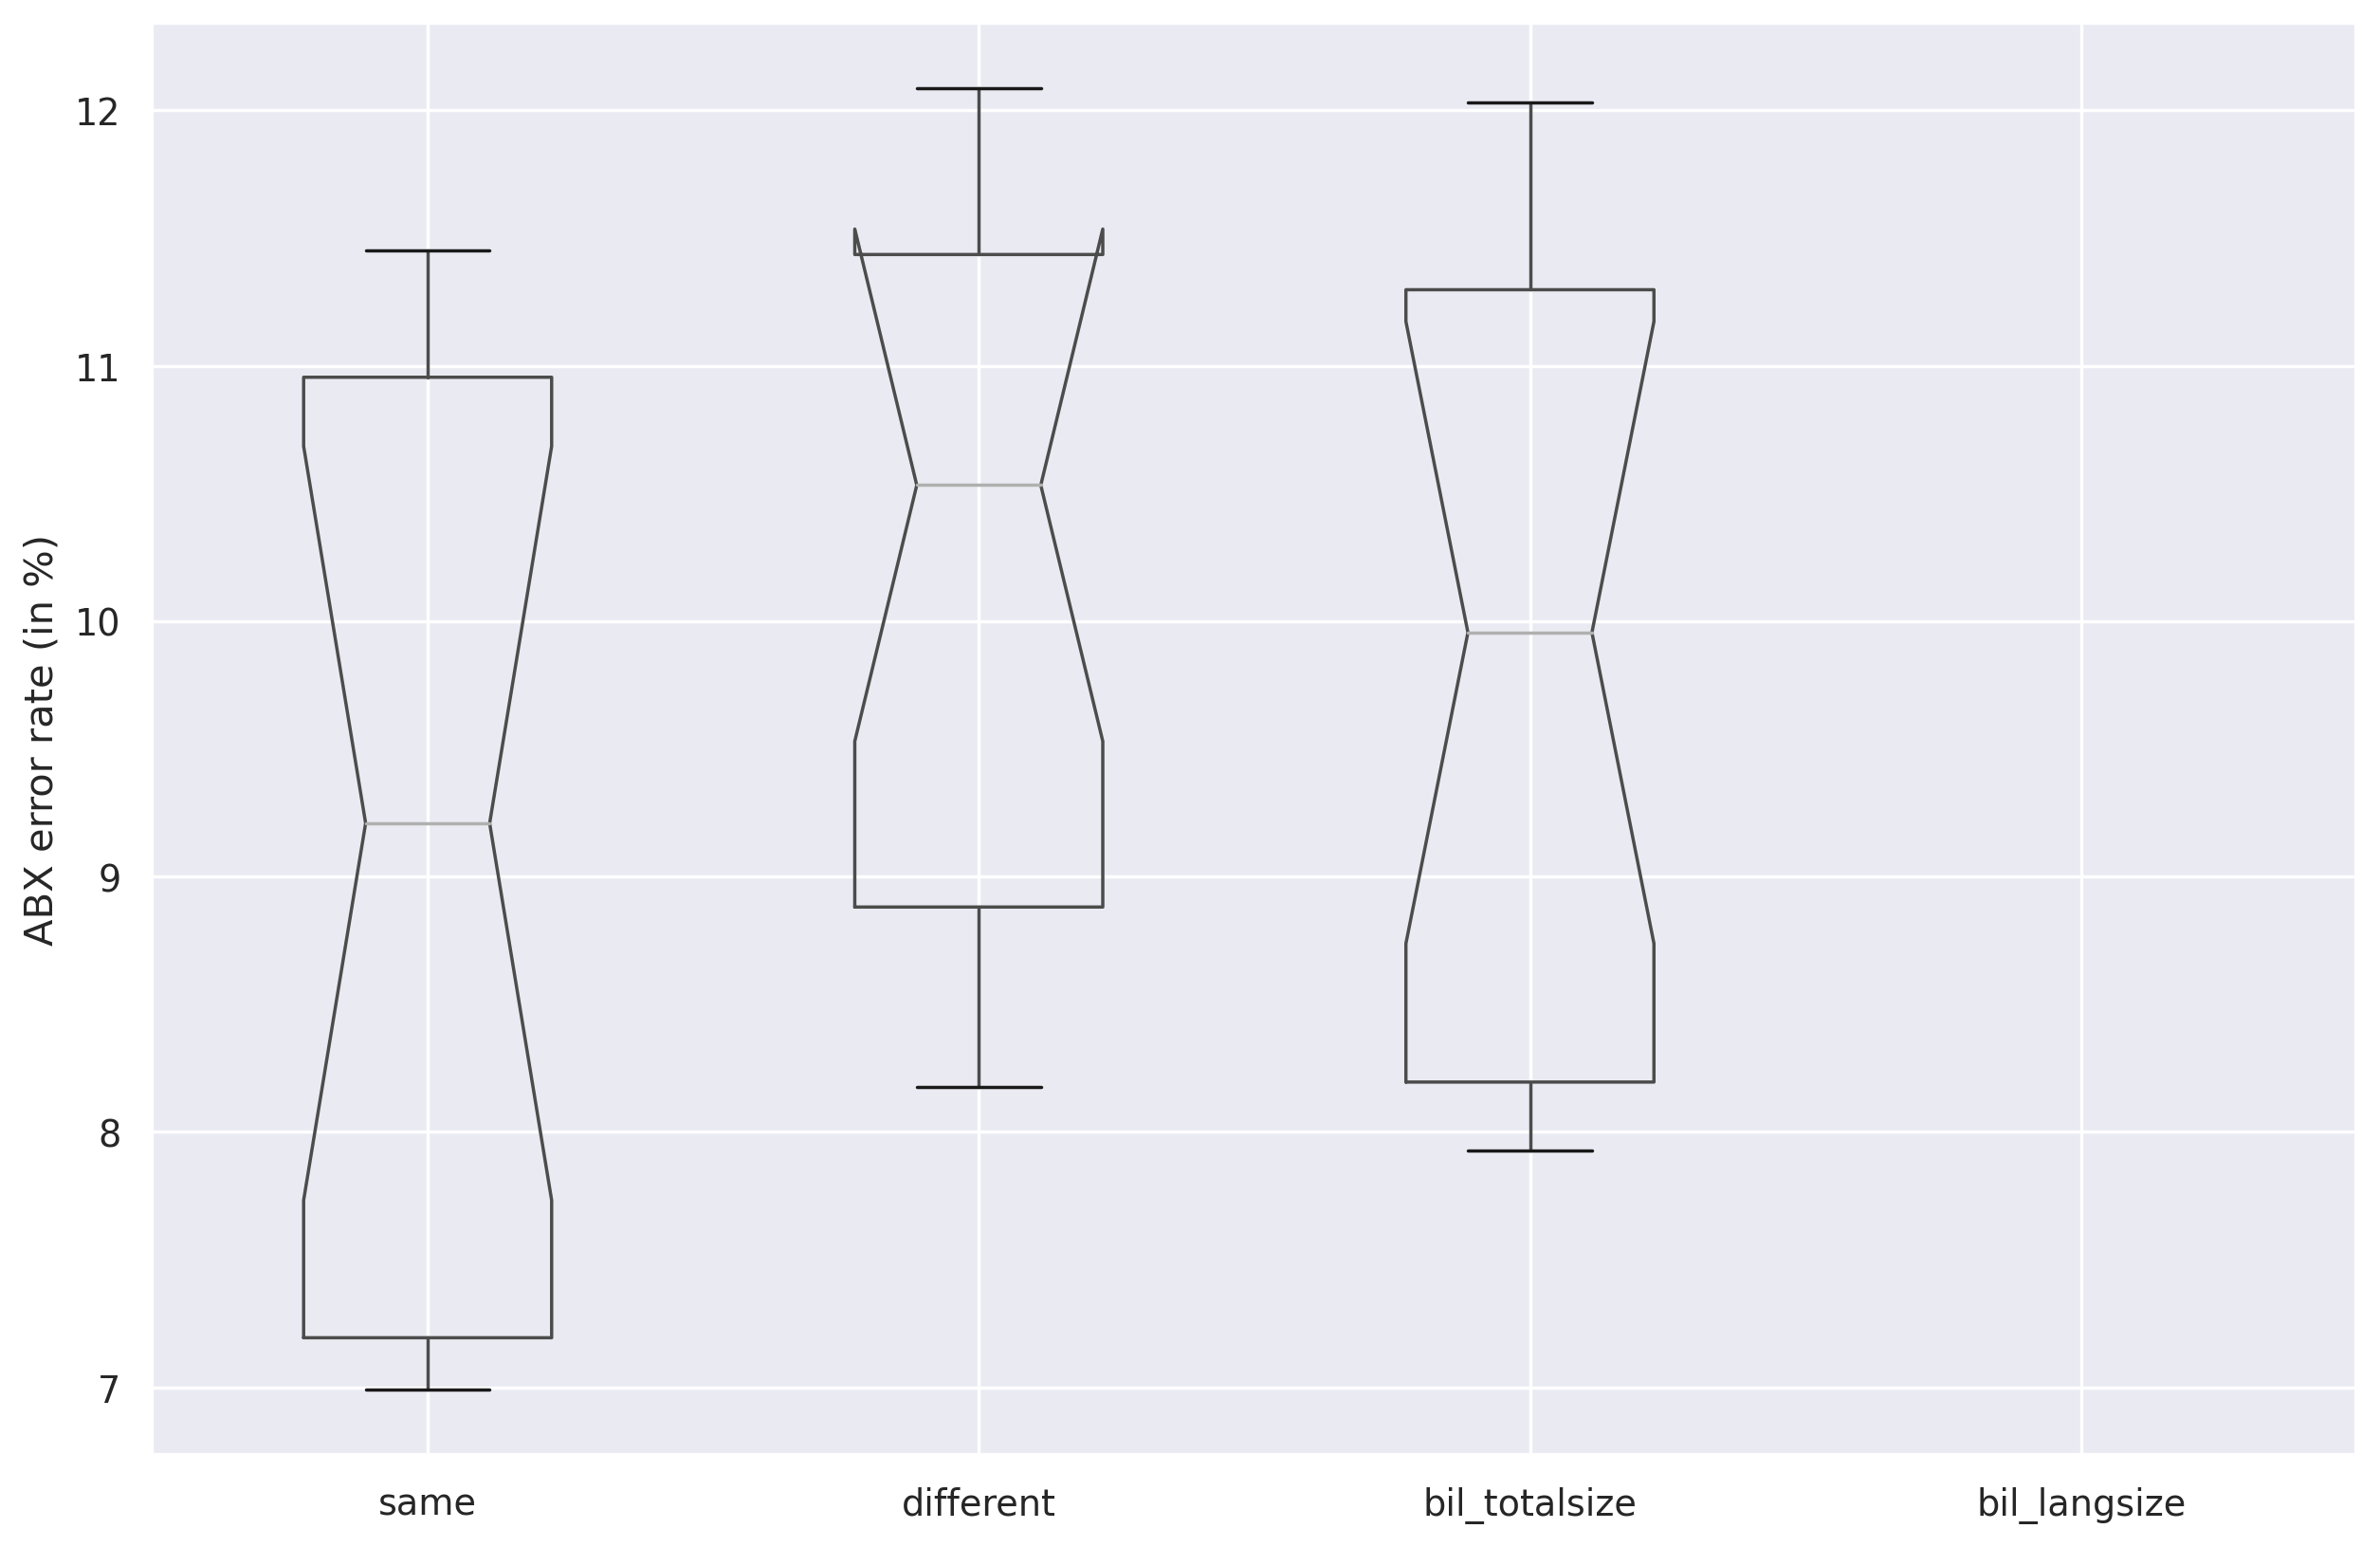

In [26]:
#need to do it symmetrically (same vs different)
boxplot = df_400h[['same', 'different', 'bil_totalsize', 'bil_langsize']].boxplot(notch=True)
boxplot.set_ylabel('ABX error rate (in %)')
# need to find a way to compare bil 200h and same_100h and diff_100h
# here we are comparing total of 200h 

In [27]:
df_400h

,fam_id,size,eval_lang,en_model,fr_model,bil_totalsize,same,different,bil_langsize,mono_avg
00_english_400,00,400,english,7.958225,8.492504,8.089115,7.958225,8.492504,NaN,8.225365
00_french_400,00,400,french,12.076964,10.459547,11.766812,10.459547,12.076964,NaN,11.268256
01_english_400,01,400,english,7.076323,8.839002,8.930916,7.076323,8.839002,NaN,7.957663
01_french_400,01,400,french,11.380353,11.449713,11.446143,11.449713,11.380353,NaN,11.415033
02_english_400,02,400,english,7.171660,8.175205,8.137824,7.171660,8.175205,NaN,7.673432
02_french_400,02,400,french,11.418563,10.696742,12.029466,10.696742,11.418563,NaN,11.057652
03_english_400,03,400,english,7.212271,9.684559,8.267571,7.212271,9.684559,NaN,8.448415
03_french_400,03,400,french,11.408790,11.339024,11.292252,11.339024,11.408790,NaN,11.373907
04_english_400,04,400,english,6.990325,8.998640,7.926421,6.990325,8.998640,NaN,7.994483
04_french_400,04,400,french,11.459187,10.883294,11.189255,10.883294,11.459187,NaN,11.171241


In [28]:
df_200h.mean(numeric_only=True)

size             200.000000
en_model           9.831553
fr_model          13.673777
bil_totalsize     10.377280
same              11.478840
different         12.026491
bil_langsize       9.804259
mono_avg          11.752665
dtype: float64

In [29]:
df_400h.mean(numeric_only=True)

size             400.000000
en_model           9.442970
fr_model           9.916283
bil_totalsize      9.804259
same               9.124924
different         10.234329
bil_langsize            NaN
mono_avg           9.679627
dtype: float64

In [30]:
np.mean([9.52668, 10.745492])

10.136086

In [31]:
#check for 200h only 